# WGAN with Conditional Gaussian Mixture


In [3]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [1]:
import os
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LightSource
from IPython.display import clear_output
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import func.propagation as prop
import func.velmodel as vmod

device = 'gpu'
labelsize = 16

# from google.colab import drive
# drive.mount('/content/drive')

2024-01-03 09:34:25.583708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 09:34:25.717463: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 09:34:26.225374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2024-01-03 09:34:26.225438: W tensorflow/comp

/tmp/ipykernel_12671/3312613403.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((600, 200), Image.LANCZOS)


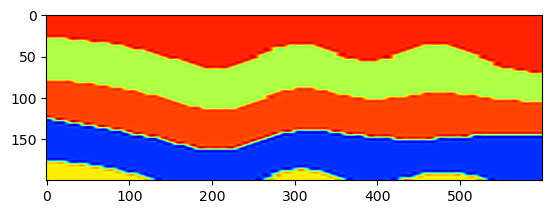

In [121]:
from PIL import Image 
n = np.random.randint(500)
img = Image.fromarray(data[n,0,:,:])
# img = Image.fromarray(np.array(cropped_images[n,:,:,0]))
img = img.resize((600, 200), Image.LANCZOS)
img = np.array(img)
img.shape
plt.imshow(img,cmap='jet')
# plt.figure()
# plt.imshow(data[n,0,:,:])

(500, 1, 70, 70)


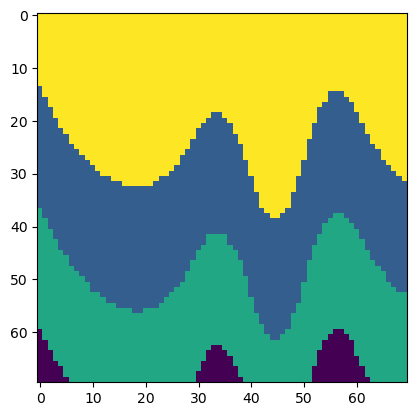

In [106]:
# Load the .npy file
# file_path = '../dataset/velocity/openfwi/curvevel_b/vel8_1_35.npy'
file_path = '../dataset/velocity/openfwi/curvevel_b/model1.npy'
data = np.load(file_path)
print(data.shape)
plt.figure()
plt.imshow(data[200,0,:,:])


## Load Dataset

(2816, 40, 120, 1)


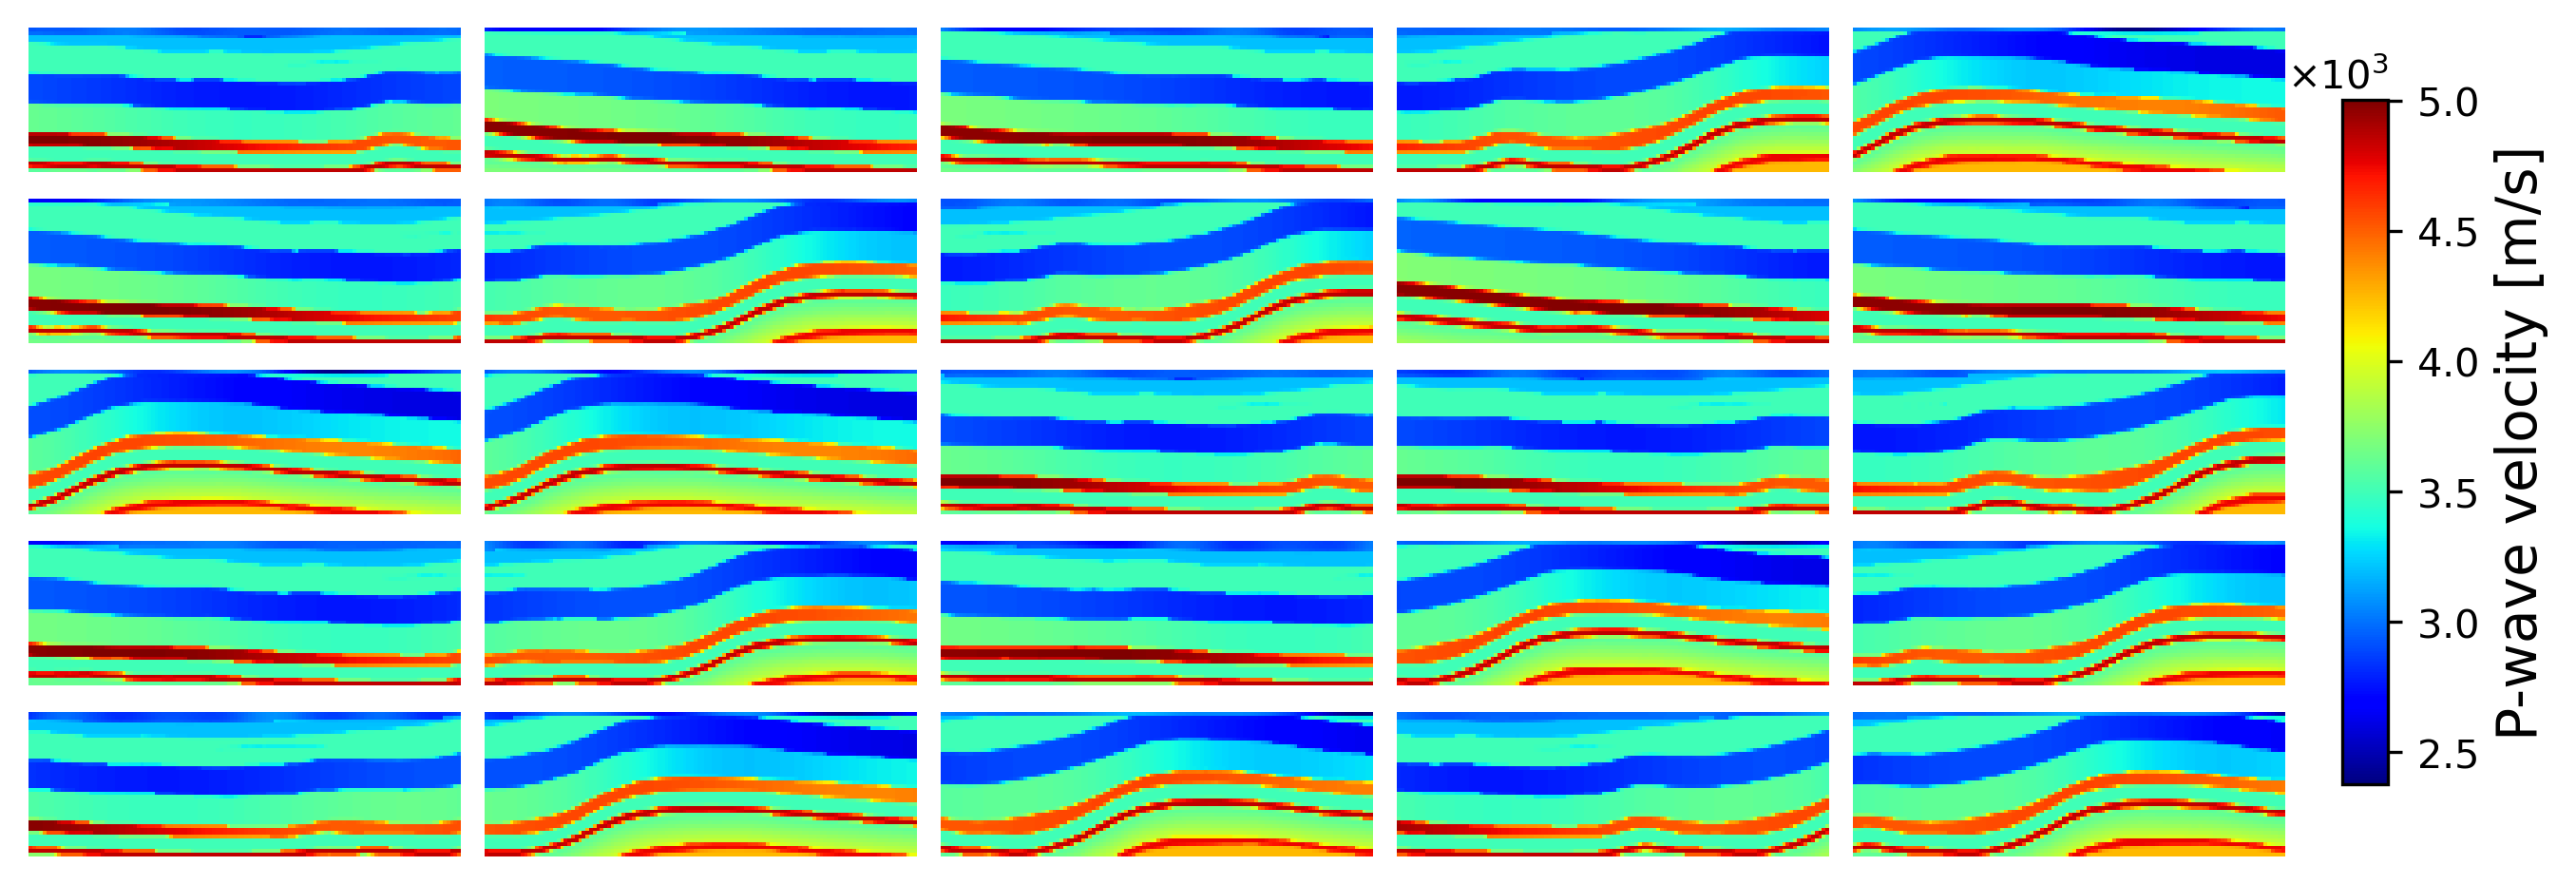

In [82]:
# n1=93 n2=401 n3=401 d1=d2=d3=50m
overthrust = vmod.readbin('../dataset/velocity/overthrust.bin',93,401*401)
# vel = vmod.readbin('/content/drive/MyDrive/yxieg/notebook/v.bin',93,401*401)
overthrust = np.reshape(overthrust,[93,401,401])
n = 120
vel = overthrust[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape
    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])
    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')
cropped_images = cropped_images[:int(n_img - n_img%256),:,:,:]

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(8, 3), dpi=300, layout="constrained")
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([1.02, 0.1, 0.02, 0.8])  # [x, y, width, height]
cbar = plt.colorbar(cax=cax)
cbar.set_label("P-wave velocity [m/s]", fontsize=14)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
# Show the plot
# plt.tight_layout()
plt.show()


## Display Overthrust Dataset

In [32]:
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D

# def plot_3D_field(array, swapz=True):
#   min_val = array.min()
#   max_val = array.max()
#   n_x, n_y, n_z = array.shape
#   colormap = plt.cm.jet

#   posx, posy, posz = n_x-1, 0, 0

#   fig = plt.figure(figsize=(15,5), dpi=300)
#   ax = fig.add_subplot(111, projection='3d')

#   x_cut = array[posx,:,:]
#   Y, Z = np.mgrid[0:n_y, 0:n_z]
#   X = posx * np.ones((n_y, n_z))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=True, alpha=0.5,
#                   facecolors=colormap((x_cut-min_val)/(max_val-min_val)))

#   y_cut = array[:,posy,:]
#   X, Z = np.mgrid[0:n_x, 0:n_z]
#   Y = posy * np.ones((n_x, n_z))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=False, alpha=0.5,
#                   facecolors=colormap((y_cut-min_val)/(max_val-min_val)))

#   z_cut = array[:,:,posz]
#   X, Y = np.mgrid[0:n_x, 0:n_y]
#   Z = posz * np.ones((n_x, n_y))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=False, alpha=0.5,
#                   facecolors=colormap((z_cut-min_val)/(max_val-min_val)))

#   # Customize the plot
#   if swapz==True: ax.invert_zaxis()
#   ax.set_xticks([0,100,200,300,400])
#   ax.set_yticks([0,100,200,300,400])
#   ax.set_zticks([0,20,40,60,80,100,120])

#   ax.set_xlabel('X', fontsize=16)
#   ax.set_ylabel('Y', fontsize=16)
#   ax.set_zlabel('Z', fontsize=16)
#   ax.set_title("3D Overthrust Model", fontsize=16)

#   # Create a color bar to display the mapping of colors to values
#   norm = plt.Normalize(min_val, max_val)
#   mappable = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
#   mappable.set_array(array)
#   cbar = plt.colorbar(mappable, ax=ax)
#   cbar.set_label('P-wave velocity [m/s]', fontsize=16)
#   cbar.formatter.set_useMathText(True)
#   cbar.formatter.set_scientific(True)
#   cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
#   cbar.update_ticks()

#   plt.show()

# data = np.swapaxes(overthrust,0,2)

# plot_3D_field(data)

### Display slices

In [33]:
# def plot_3D_field(array, swapz=True):
#   min_val = array.min()
#   max_val = array.max()
#   n_x, n_y, n_z = array.shape
#   colormap = plt.cm.jet

#   fig = plt.figure(figsize=(15,5), dpi=300)
#   ax = fig.add_subplot(111, projection='3d')

#   for i in range(0, 290, 200):
#     for j in range(0,10):
#       y_cut = array[i:121+i,40*j,:41]
#       X, Z = np.mgrid[i:120+i, :40]
#       Y = 40*j * np.ones((120, 40))
#       ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=False, edgecolors='k', lw=3,
#                       facecolors=colormap((y_cut-min_val)/(max_val-min_val)))
  
#   posx, posy, posz = n_x-1, n_y-1, n_z-1
#   x_cut = array[posx,:,:]
#   Y, Z = np.mgrid[0:n_y, 0:n_z]
#   X = posx * np.ones((n_y, n_z))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=True, alpha=0.05,
#                   facecolors=colormap((x_cut-min_val)/(max_val-min_val)))

#   y_cut = array[:,posy,:]
#   X, Z = np.mgrid[0:n_x, 0:n_z]
#   Y = posy * np.ones((n_x, n_z))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=False, alpha=0.05,
#                   facecolors=colormap((y_cut-min_val)/(max_val-min_val)))

#   z_cut = array[:,:,posz]
#   X, Y = np.mgrid[0:n_x, 0:n_y]
#   Z = posz * np.ones((n_x, n_y))
#   ax.plot_surface(X, Y, Z, rstride=1, cstride=1, shade=False, alpha=0.01,
#                   facecolors=colormap((z_cut-min_val)/(max_val-min_val)))

#   # Customize the plot
#   if swapz==True: ax.invert_zaxis()
#   ax.set_xticks([0,100,200,300,400])
#   ax.set_yticks([0,100,200,300,400])
#   ax.set_zticks([0,20,40,60,80,100,120])

#   ax.set_xlabel('X', fontsize=16)
#   ax.set_ylabel('Y', fontsize=16)
#   ax.set_zlabel('Z', fontsize=16)
#   ax.set_title("Training Data", fontsize=16)

#   # Create a color bar to display the mapping of colors to values
#   norm = plt.Normalize(min_val, max_val)
#   mappable = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
#   mappable.set_array(array)
#   cbar = plt.colorbar(mappable, ax=ax)
#   cbar.set_label('P-wave velocity [m/s]', fontsize=16)
#   cbar.formatter.set_useMathText(True)
#   cbar.formatter.set_scientific(True)
#   cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
#   cbar.update_ticks()

#   plt.show()

# data = np.swapaxes(overthrust,0,2)

# plot_3D_field(data)

## Normalize images

In [34]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 256
dim_z = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

-0.99999994 0.99999994


## Define Generator and Discriminator

In [5]:
kernal_size = (5, 5)
kernal_size_2 = (7, 7)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(PixelShuffle(scale=2))  # Add Pixel Shuffle with scale 2

    model.add(layers.Conv2DTranspose(256, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def gradient_penalty(batch_size, real_images, fake_images):
    """Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # For each batch, we are going to perform the
    # following steps as laid out in the original paper:
    # 1. Train the generator and get the generator loss
    # 2. Train the discriminator and get the discriminator loss
    # 3. Calculate the gradient penalty
    # 4. Multiply this gradient penalty with a constant weight factor
    # 5. Add the gradient penalty to the discriminator loss
    # 6. Return the generator and discriminator losses as a loss dictionary
    extra_step = 5
    weight = 10.0

    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    for i in range(extra_step):
      # Get the latent vector
      noise = tf.random.normal([BATCH_SIZE, dim_z])
      with tf.GradientTape() as tape:
        # Generate fake images from the latent vector
        fake_images = generator(noise, training=True)
        # Get the logits for the fake images
        fake_logits = discriminator(fake_images, training=True)
        # Get the logits for the real images
        real_logits = discriminator(images, training=True)

        # Calculate the discriminator loss using the fake and real image logits
        d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
        # Calculate the gradient penalty
        gp = gradient_penalty(BATCH_SIZE, images, fake_images)
        # Add the gradient penalty to the original discriminator loss
        d_loss = d_cost + gp * weight

      # Get the gradients w.r.t the discriminator loss
      d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
      # Update the weights of the discriminator using the discriminator optimizer
      discriminator_optimizer.apply_gradients(
          zip(d_gradient, discriminator.trainable_variables)
      )

    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([BATCH_SIZE, dim_z])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs):
  loss_history = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      loss = train_step(image_batch)
    loss_history.append(loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             loss_history)

    # Save the model every n epochs
    if (epoch + 1) % 250 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           loss_history)
  return loss_history

def generate_and_save_images(model, epoch, test_input, loss_history):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 8),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(10, 5, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  # plt.savefig('./dcgan/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


  fig = plt.figure(figsize=(8, 4),dpi=100)
  plt.plot(loss_history)
  plt.legend(['Generator loss', 'Discriminator loss'])
  plt.show()

## Train the model

2023-12-22 16:17:06.804050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


tf.Tensor([[5.232372e-06]], shape=(1, 1), dtype=float32)


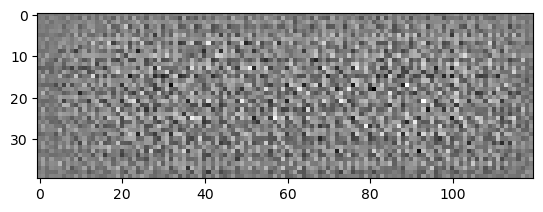

In [6]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)

checkpoint_dir = '../dataset/checkpoint/wgan_gp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50000
num_examples_to_generate = 50
seed = tf.random.normal([num_examples_to_generate, dim_z])

restore = 1
training = 0
if restore==True: checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if training==True: loss_history = train(train_dataset, EPOCHS)

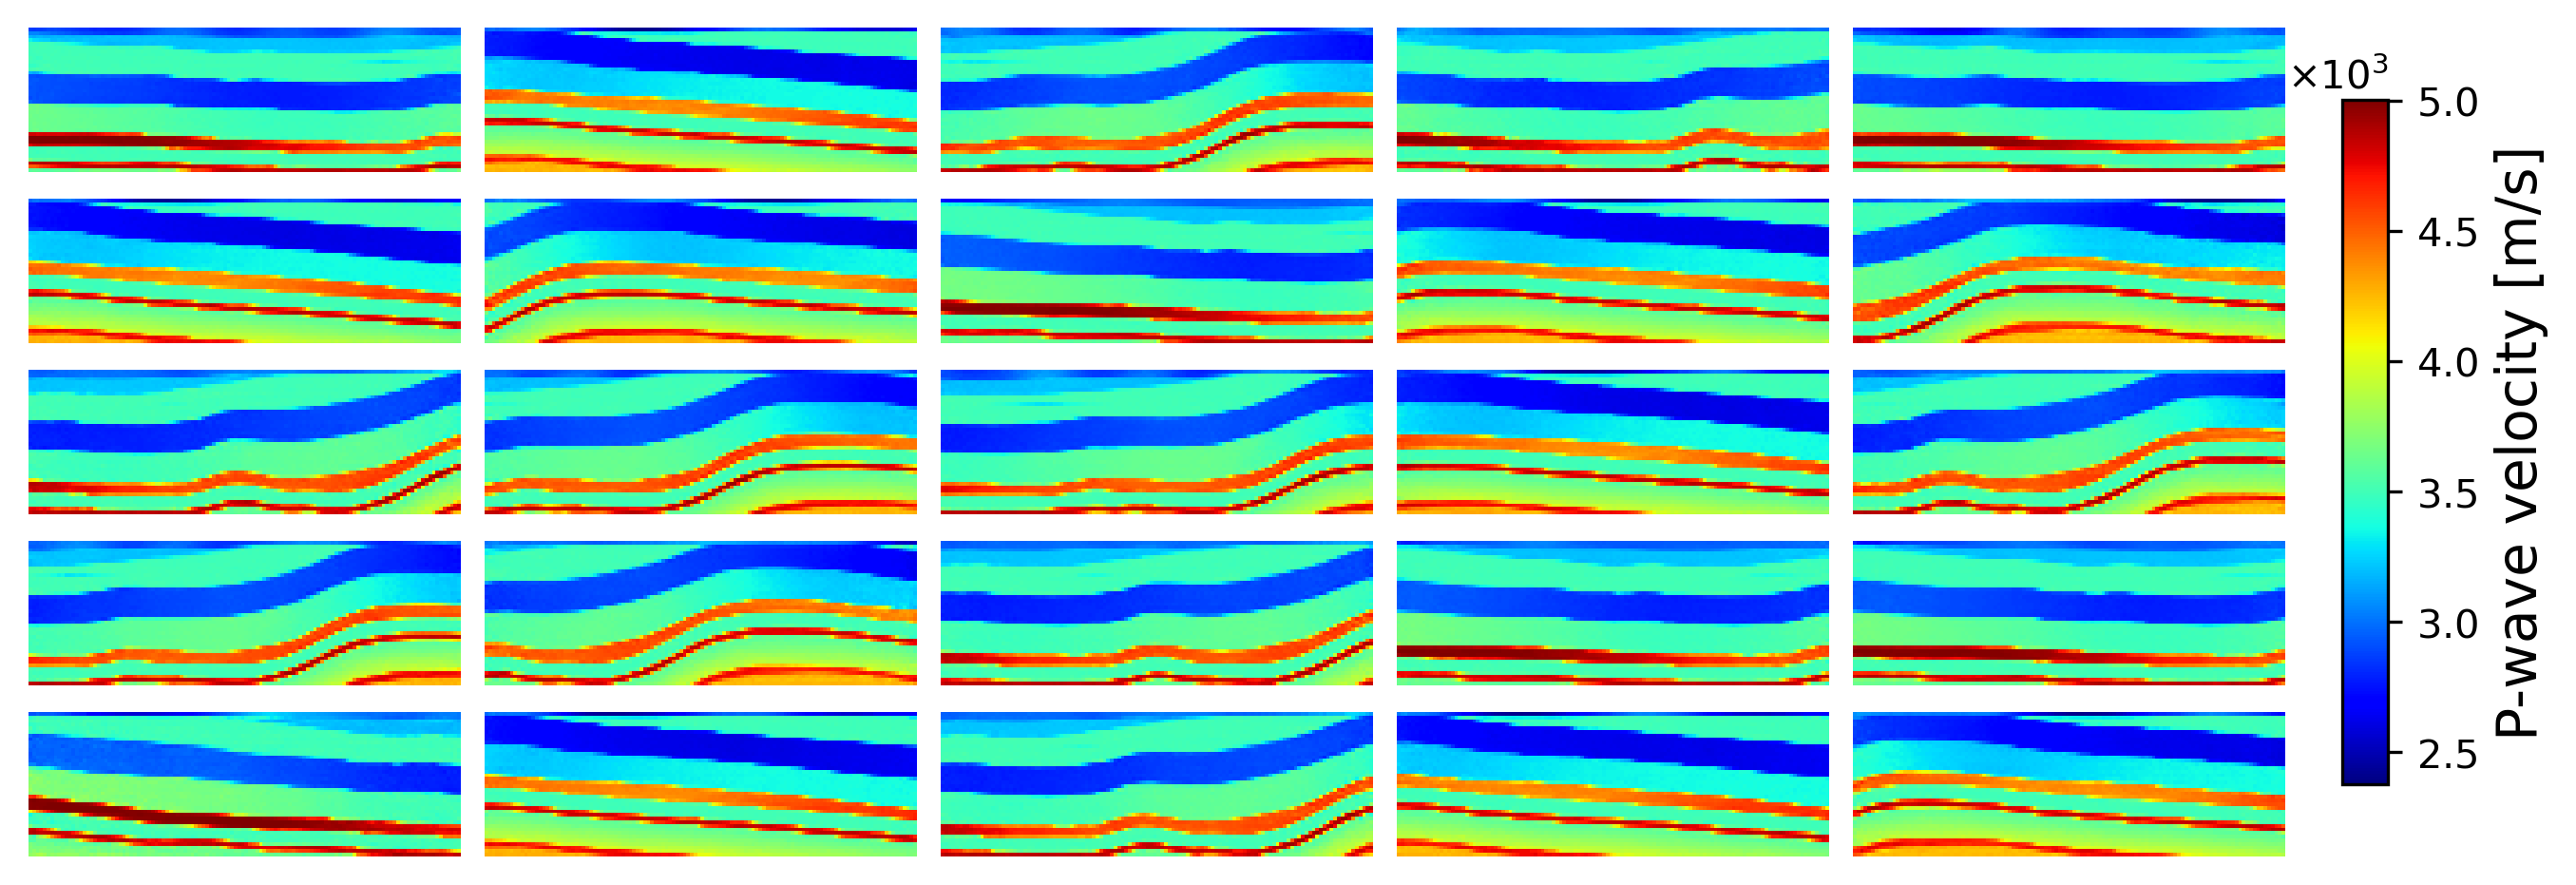

In [7]:
seed = tf.random.normal([num_examples_to_generate, dim_z])
Gz = generator(seed, training=False)

fig = plt.figure(figsize=(8, 3), dpi=300, layout="constrained")
for i in range(25):
  plt.subplot(5, 5, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([1.02, 0.1, 0.02, 0.8])  # [x, y, width, height]
cbar = plt.colorbar(cax=cax)
cbar.set_label("P-wave velocity [m/s]", fontsize=14)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
# Show the plot
# plt.tight_layout()
plt.show()

# Forward Modeling

Min velocity: 2432.29  Max velocity 4850.00
dz,dx,dt (m): 9.504880859375 9.504880859375 0.0012094673270528794
Model dimension [nz,nx,nt]:  40 120 600


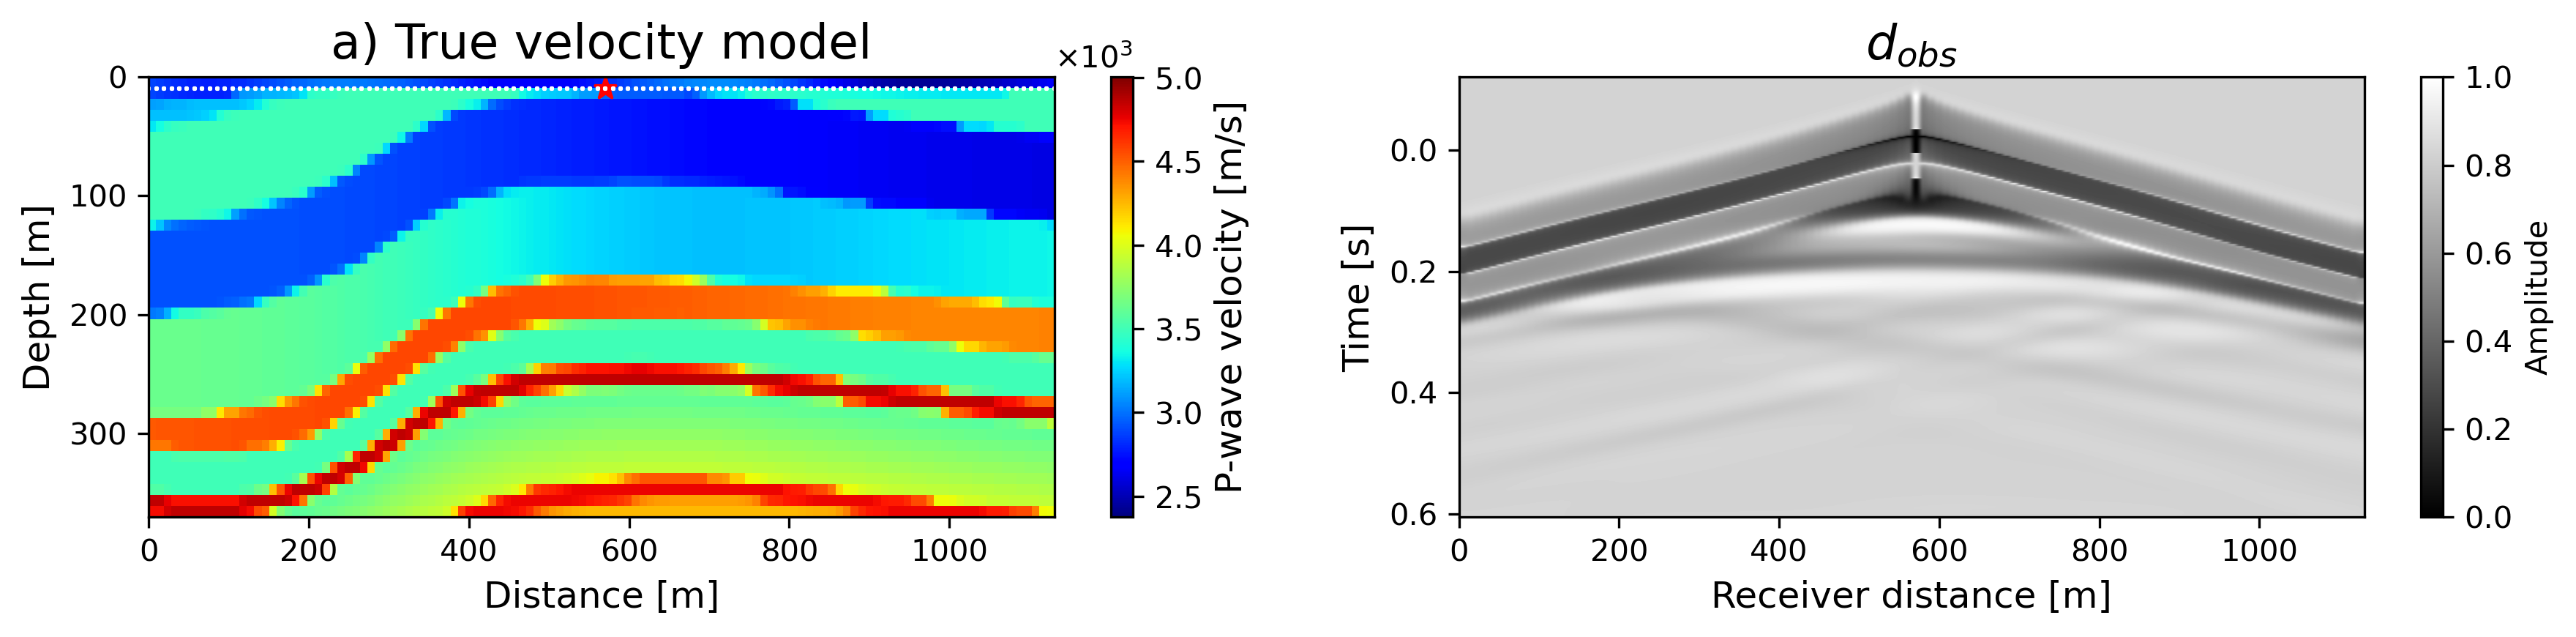

In [8]:
def disp_fwd(vel, d_obs):
	plt.figure(figsize=(12,3), dpi=300)
	plt.subplot(1,2,1)
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=50,alpha=1,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.1,alpha=1,label="Receivers")
	# plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	seismic_data = tf.transpose(d_obs[0]).numpy()
	ls = LightSource(azdeg=180, altdeg=45)
	cmap = plt.cm.gist_earth
	hillshaded = ls.hillshade(seismic_data, vert_exag=20, fraction=1.0)
	plt.imshow(hillshaded, cmap='gray',
						vmin=0,vmax=1,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	# plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("$d_{obs}$", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()


# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,600
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

# v_ref = cropped_images[860,:,:,0].numpy()
v_ref = cropped_images[200,:,:,0].numpy()
# v_ref = cropped_images[170,:,:,0].numpy()
# v_ref = cropped_images[700,:,:,0].numpy()

# vel   = vmod.readbin('../dataset/velocity/marm2_sel.dat',201,601)
# # vel = vel[::4,::4][-40:,-140:-20]*1e3
# vel = vel[::5,::5][1:,1:]*1e3
# print(vel.shape)
# vel = (vel - vel.min()) / (vel.max() - vel.min())
# v_ref = vmin + vel*(vmax-vmin)

# seed = tf.random.normal([num_examples_to_generate, dim_z])
# Gz = generator(seed, training=False)
# Gz_i = inverse_norm(Gz[0,:,:,0],vmin,vmax)
# v_ref = Gz_i.numpy().flatten()
# mu=0

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = prop.defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]

# Set sourse and receiver coordinates: shape=(2,nrec)
nsrc = 1
zxsrc = np.vstack((np.ones(nsrc),(np.arange(nsrc)+1)*nx//(nsrc+1))).astype(int)
zxrec = np.vstack((np.ones(nx), np.arange(0,nx))).astype(int) # Receivers everywhere at top

nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop.prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next, device)
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

## Deterministic Inversion

In [25]:
from scipy.optimize import minimize

def callback(x):
    clear_output(wait=True)
    # losses.append(x.fun)

    plt.figure(figsize=(10,5), dpi=300)
    # Plot the true velocity
    plt.subplot(221)
    plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=50,alpha=1,label="Source")
    plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.1,alpha=1,label="Receivers")
    # plt.legend(loc='upper right',fontsize=labelsize-8)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(a) True velocity model",fontsize=labelsize)

    plt.subplot(222)
    seismic_data = tf.transpose(d_obs[0]).numpy()
    # plt.imshow(ls.hillshade(seismic_data, vert_exag=1, fraction=1.0), cmap='gray',vmin=-5,vmax=5,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
    plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label("Amplitude")
    plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
    plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
    plt.ylabel('Time [s]', fontsize=labelsize-4)

    # Display current velocity field
    plt.subplot(223)
    plt.imshow(x.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) FWI result $V_0=4\\times10^3$",fontsize=labelsize)

    # Plot the initial velocity
    plt.subplot(224)
    plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(d) Initial velocity model",fontsize=labelsize)

    # Display loss track
    # plt.subplot(224)
    # plt.plot(losses,lw=1.5)
    # # Set the x-axis tick formatter to scientific notation
    # formatter = ScalarFormatter(useMathText=True)
    # formatter.set_scientific(True)
    # formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
    # plt.gca().yaxis.set_major_formatter(formatter)
    # plt.legend(['Data misfit'])
    # plt.xlim(xmin=0)
    # plt.ylim(ymin=0)
    # plt.xlabel('Epoch', fontsize=labelsize-4)
    # plt.ylabel('Loss', fontsize=labelsize-4)
    # plt.title("(d) Optimization history",fontsize=labelsize)

    plt.tight_layout()
    plt.show()

from scipy.ndimage import gaussian_filter
v_init = gaussian_filter(v_ref,3).flatten()
# v_init = 4. * 1e3 * np.ones(nz*nx)

losses = []
resi = minimize(fun = prop.misfit, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init), 2), (vmin,vmax)),
               jac = prop.adjoint_gradient, # Jacobian
               options = {'disp':True, 'maxiter':5000},
               callback = callback
              )
v_fwi = resi.x

KeyboardInterrupt: 

([], [])

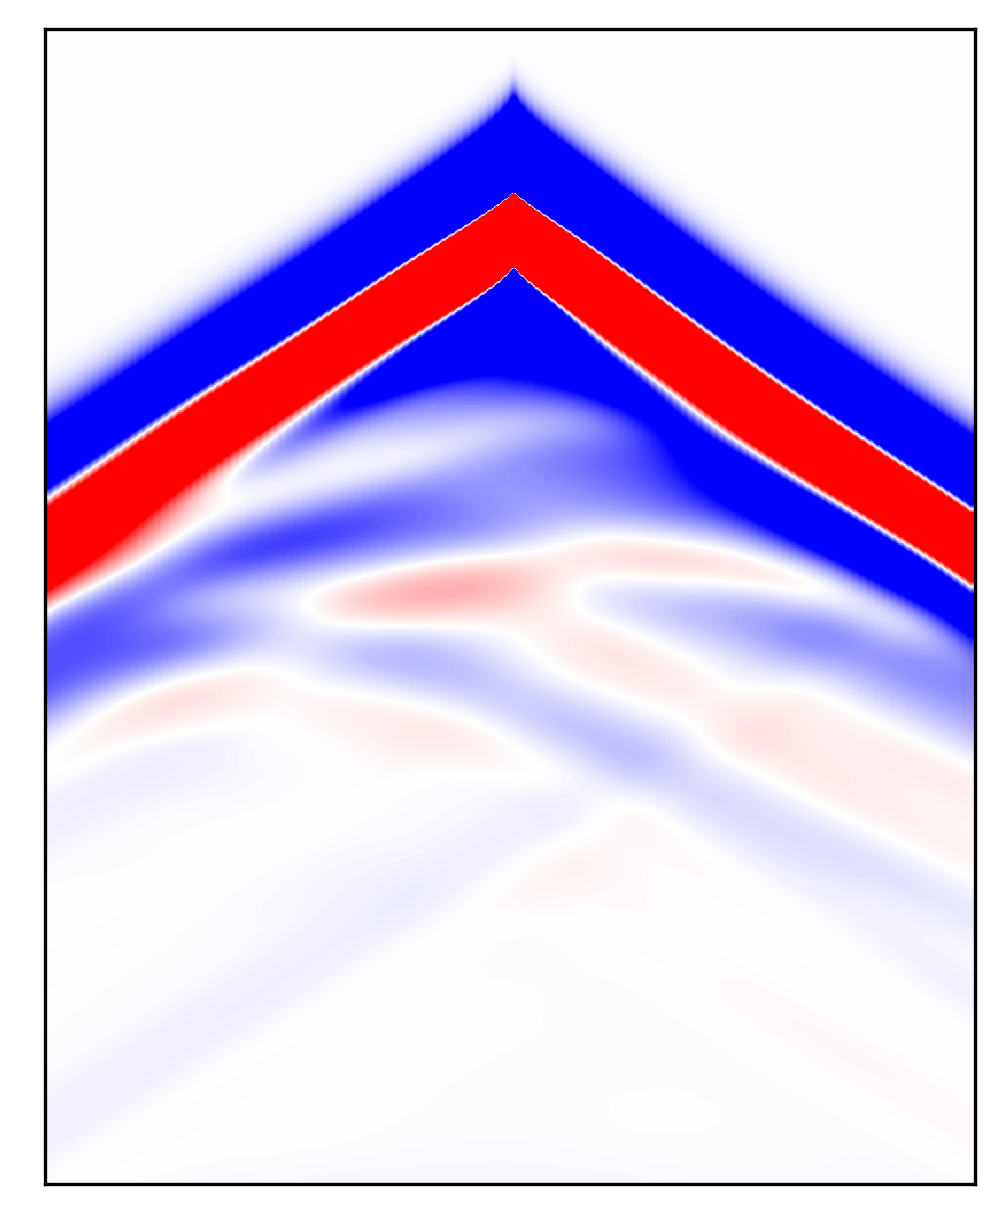

In [71]:
plt.figure(figsize=(4,5), dpi=300)
seismic_data = tf.transpose(d_obs[0]).numpy()
# plt.imshow(ls.hillshade(seismic_data, vert_exag=1, fraction=1.0), cmap='gray',vmin=-5,vmax=5,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
# plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
plt.imshow(seismic_data,cmap='bwr',vmin=-1,vmax=1, aspect='auto')
# cbar = plt.colorbar()
# cbar.set_label("Amplitude")
# plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
# plt.xlabel('Trace', fontsize=labelsize-4)
# plt.ylabel('Time [s]', fontsize=labelsize-4)
plt.xticks([])
plt.yticks([])

In [16]:
plt.figure(figsize=(5,2), dpi=300)
plt.imshow(v_fwi.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance x[m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
# plt.title("(c) FWI result $V_0=4\\times10^3$",fontsize=labelsize)


# Plot the initial velocity
plt.figure(figsize=(5,2), dpi=300)
plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance x[m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
# plt.title("(d) Initial velocity model",fontsize=labelsize)

NameError: name 'v_fwi' is not defined

<Figure size 1500x600 with 0 Axes>

## Deterministic with GAN

Iteration 51


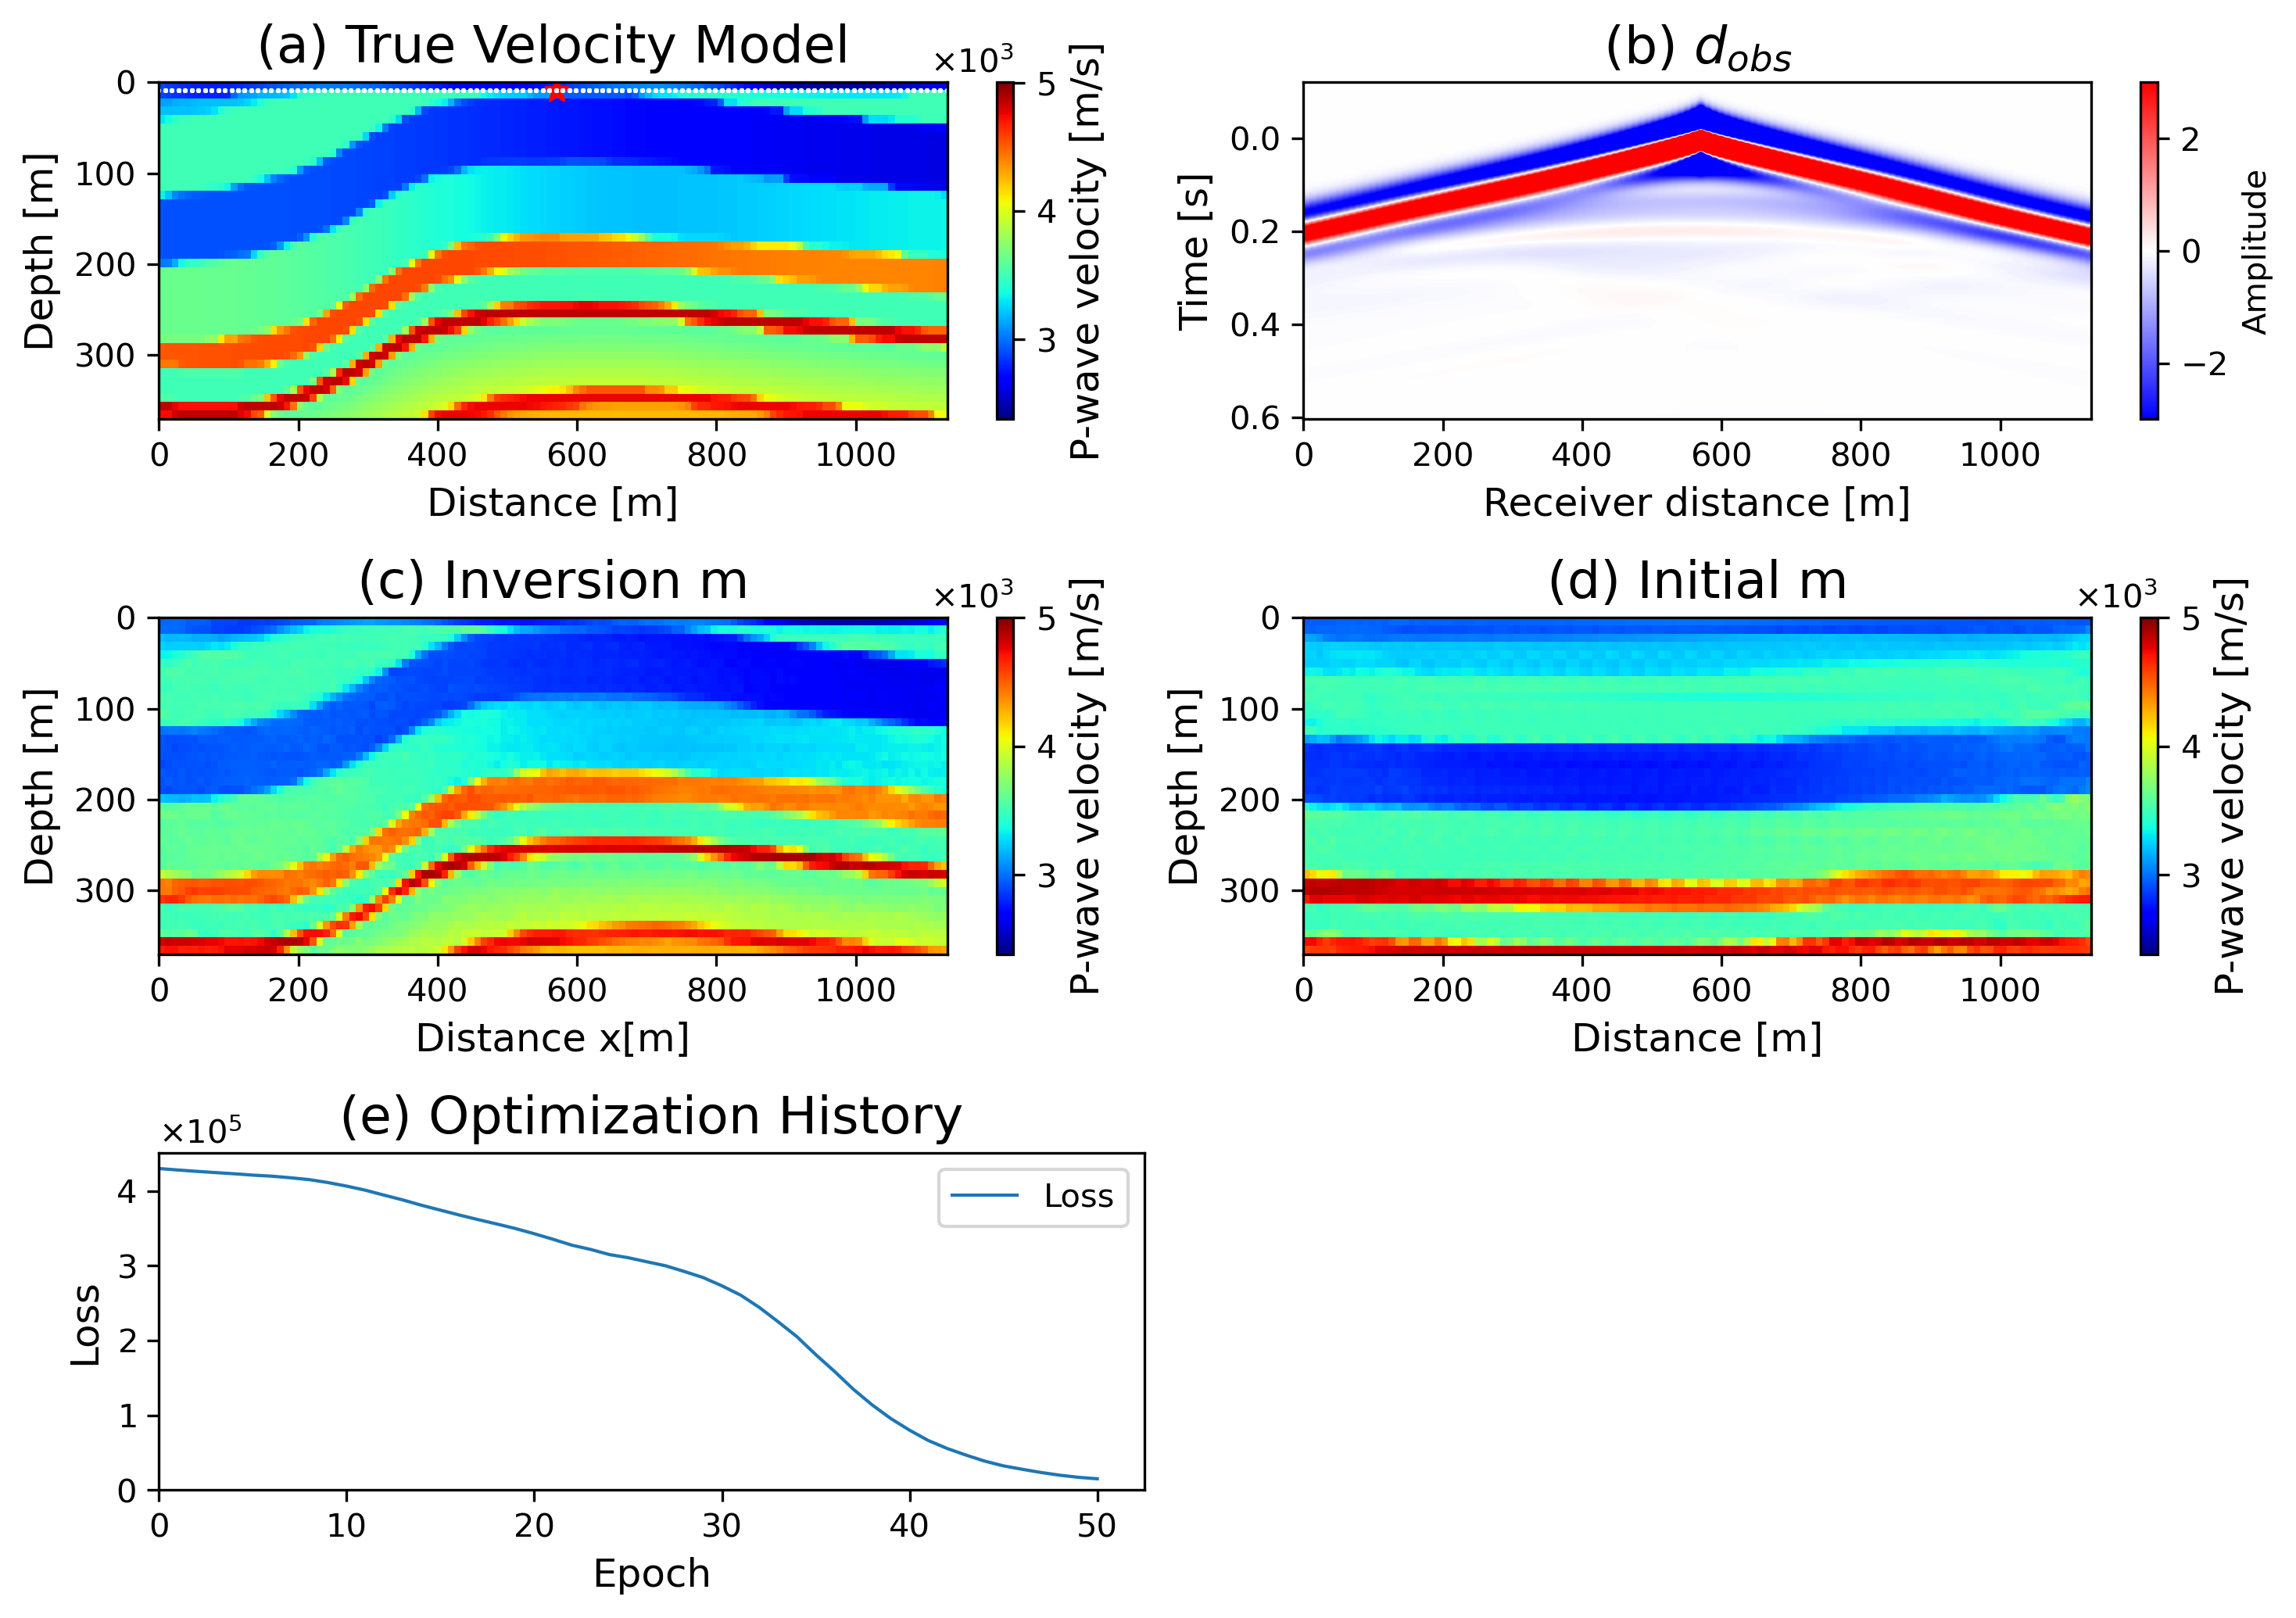

(1, 100)


KeyboardInterrupt: 

In [64]:
def plot_loss():
  # Display current velocity field
  clear_output(wait=True)
  print('Iteration', int(epoch))

  plt.figure(figsize=(10,7), dpi=300)
  # Plot the true velocity
  plt.subplot(321)
  plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=50,alpha=1,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.1,alpha=1,label="Receivers")
  # plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(a) True Velocity Model",fontsize=labelsize)

  plt.subplot(322)
  ls = LightSource(azdeg=0, altdeg=1)
  seismic_data = tf.transpose(d_obs[0]).numpy()
  # plt.imshow(ls.hillshade(seismic_data, vert_exag=1, fraction=1.0), cmap='gray',vmin=-5,vmax=5,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
  plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.set_label("Amplitude")
  plt.title("(b) $d_{obs}$", fontsize=labelsize)
  plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
  plt.ylabel('Time [s]', fontsize=labelsize-4)

  # Plot the velocity field at current iteration
  plt.subplot(323)
  plt.imshow(m.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(c) Inversion m",fontsize=labelsize)

  # Plot the initial velocity
  plt.subplot(324)
  plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(d) Initial m",fontsize=labelsize)

  # Display loss track
  plt.subplot(325)
  plt.plot(loss_tracker,lw=1)
  # Set the x-axis tick formatter to scientific notation
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend(['Loss'])
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlabel('Epoch', fontsize=labelsize-4)
  plt.ylabel('Loss', fontsize=labelsize-4)
  plt.title("(e) Optimization History",fontsize=labelsize)

  plt.tight_layout()
  plt.show()

@tf.custom_gradient
def dJ_dm(vel):
  loss_J = prop.misfit(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
  loss_J = tf.cast(loss_J, tf.float32)

  def grad_fn(upstream):
      grad = prop.adjoint_gradient(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
      return upstream * tf.cast(grad, tf.float32)
  return loss_J, grad_fn

determ_optimizer = tf.keras.optimizers.Adam(1e-3)
loss_tracker = []
sigma2 = 1e-1  # Noise level
epoch_vels = []
# noise_z = tf.random.normal([1, dim_z])
noise_z = tf.Variable(tf.zeros([1, dim_z]))
Gz = generator(noise_z, training=False)
Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
v_init = tf.reshape(Gz, -1)

for epoch in range(100):
  with tf.GradientTape() as tape:
    tape.watch(noise_z)
    # Generate image from G(z)
    Gz = generator(noise_z, training=False)
    Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
    m = tf.reshape(Gz, -1)
    # Forward propagation & Adjoint back propagation
    J = dJ_dm(m)
    loss = J/(1e-6+sigma2) + tf.reduce_sum(noise_z**2)
    # Plot result
    plot_loss()
    # Save loss
    loss_tracker.append(loss)  
    # Compute gradient of loss w.r.t.  
    grad = tape.gradient(loss, noise_z)
    print(grad.shape)
    determ_optimizer.apply_gradients(zip([grad], [noise_z]))

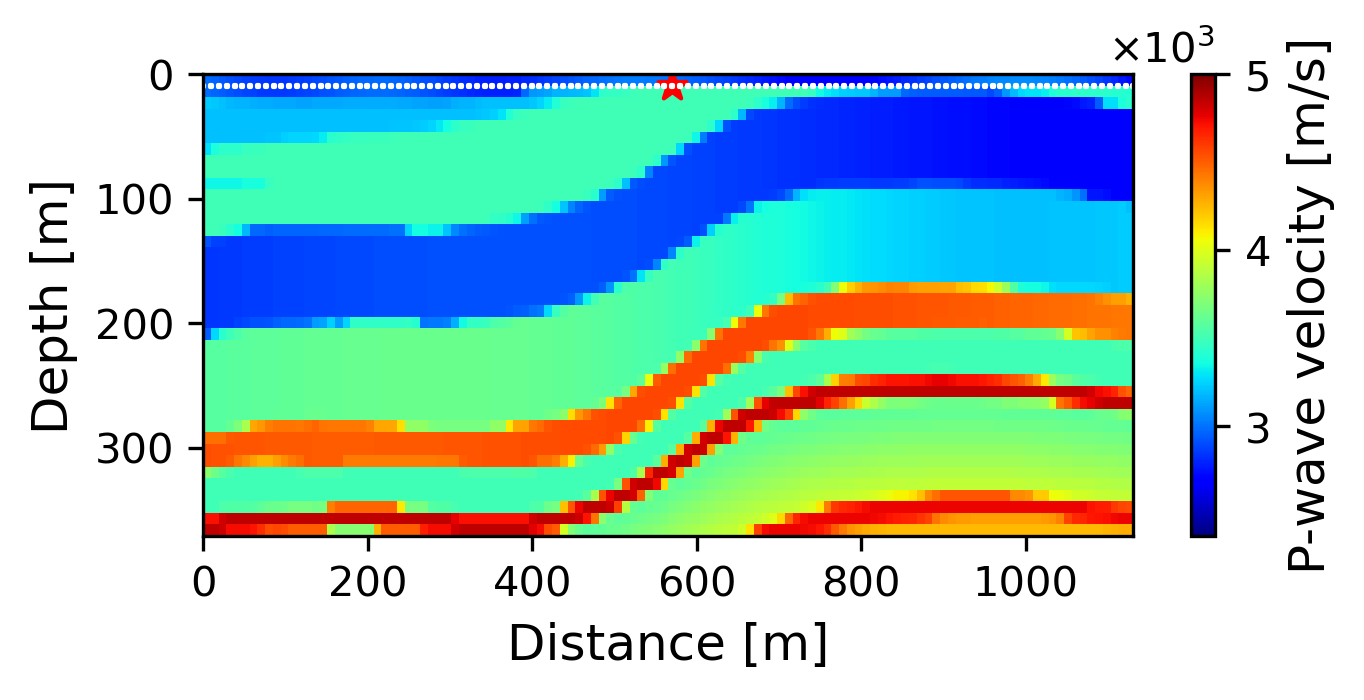

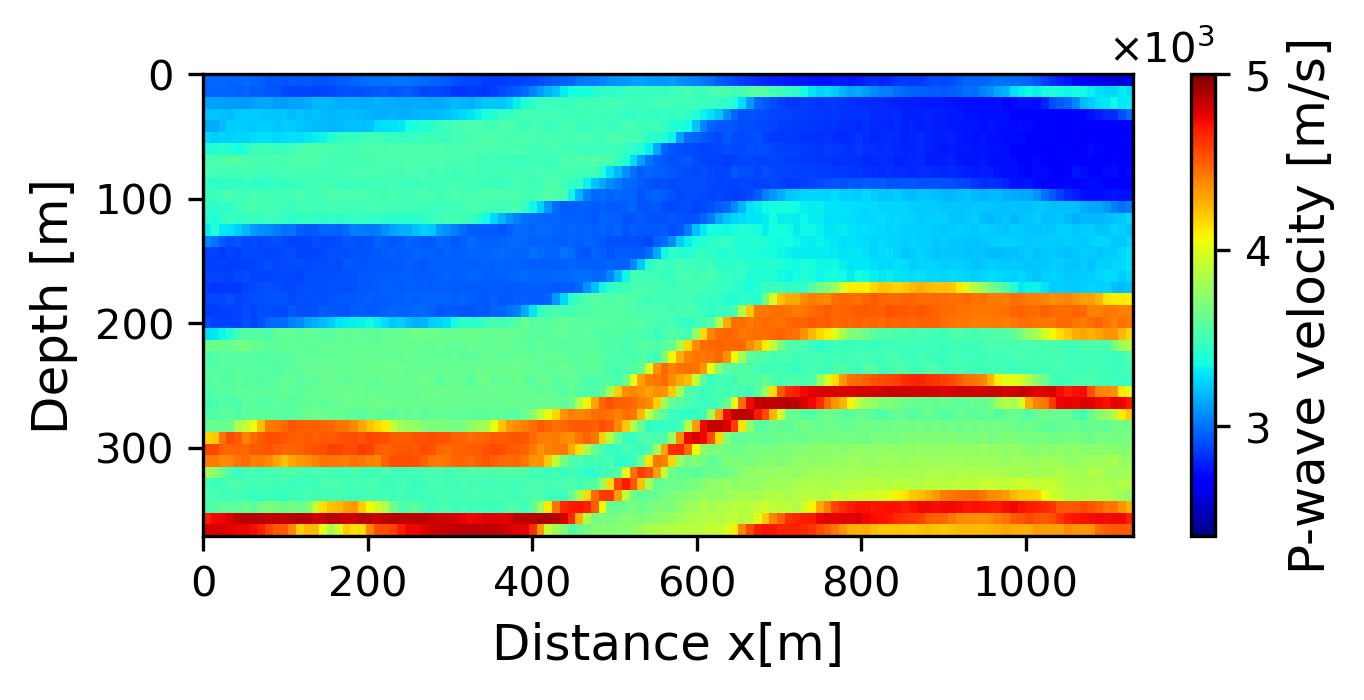

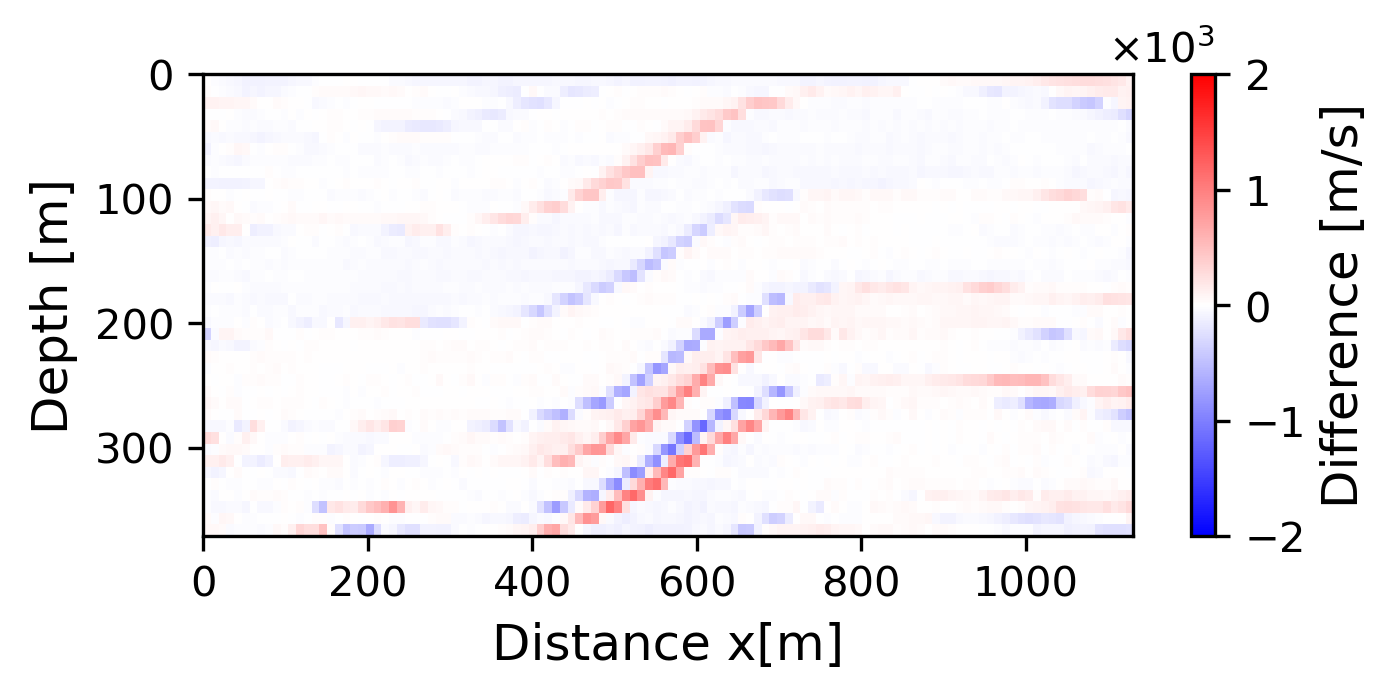

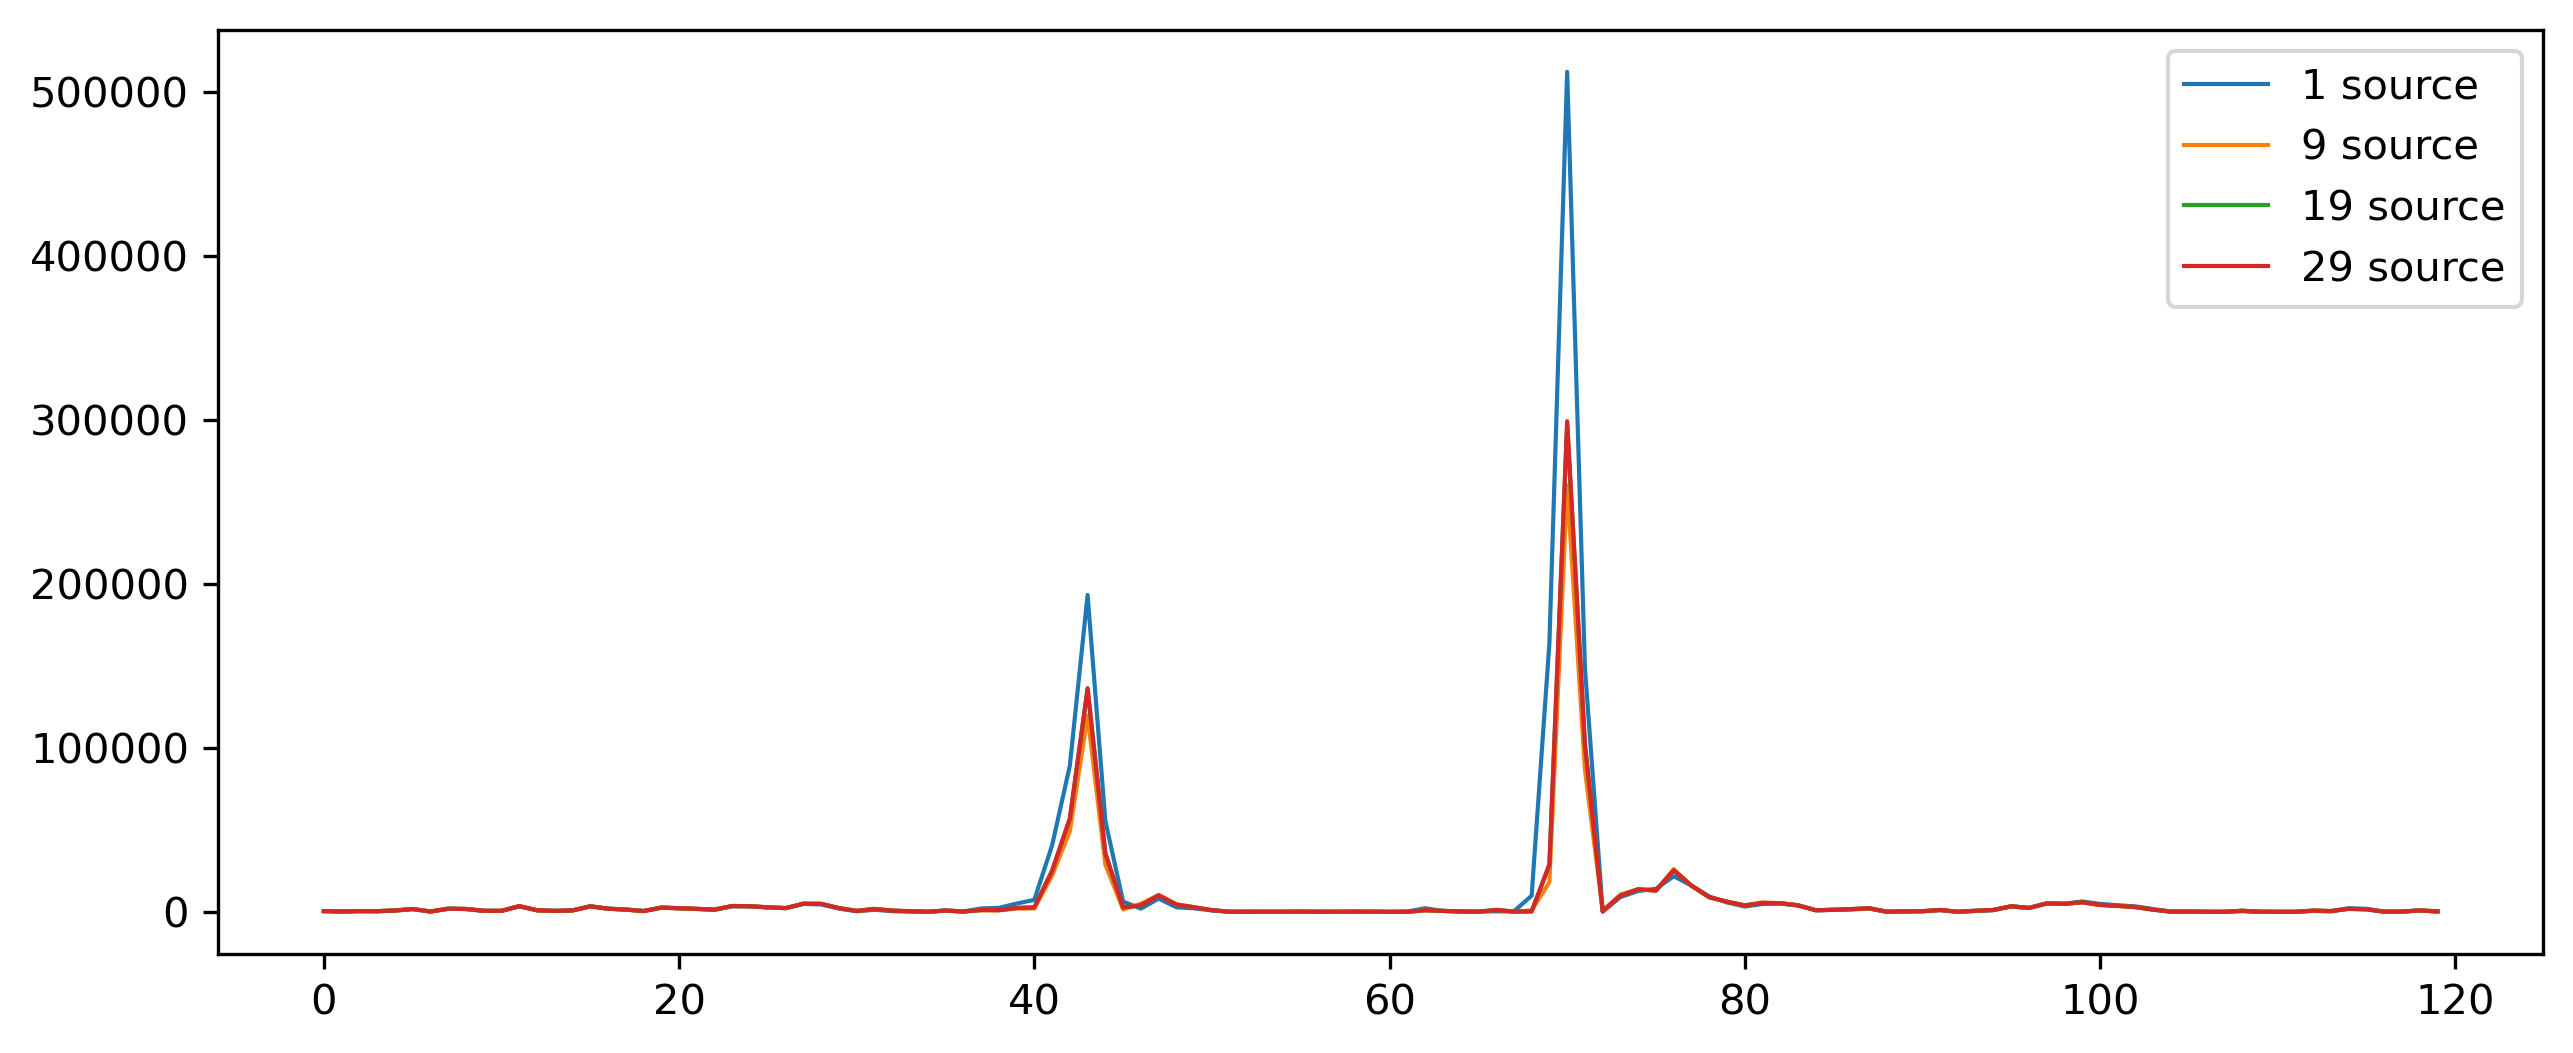

In [90]:
# Reference field
plt.figure(figsize=(5,2), dpi=300)
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=50,alpha=1,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.1,alpha=1,label="Receivers")
# plt.legend(loc='upper right',fontsize=labelsize-8)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.savefig('../paper/ConventionalFWI/'+str(nsrc)+'_source_true_velocity.png')
# plt.title("(a) True Velocity Model",fontsize=labelsize)

# GAN inversion
plt.figure(figsize=(5,2), dpi=300)
plt.imshow(m.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance x[m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.savefig('../paper/ConventionalFWI/'+str(nsrc)+'_source_gan.png')
# plt.title("(c) Inversion m",fontsize=labelsize)

# Differences
# Conventional inversion
plt.figure(figsize=(5,2), dpi=300)
plt.imshow(v_ref.reshape((nz,nx))-m.numpy().reshape((nz,nx)),vmin=-2000,vmax=2000,cmap='bwr',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("Difference [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance x[m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.savefig('../paper/ConventionalFWI/'+str(nsrc)+'_source_diff.png')


# diff = (v_ref.flatten()-m.numpy())**2
# plt.hist(diff, bins=50,density=True,histtype='step')
# plt.show()

plt.figure(figsize=(10,4),dpi=300)
diff1 = v_ref-m.numpy().reshape((nz,nx))
plt.plot((diff1[20,:])**2,lw=1, label='1 source')
plt.plot((diff9[20,:])**2,lw=1, label='9 source')
plt.plot((diff19[20,:])**2,lw=1, label='19 source')
plt.plot((diff29[20,:])**2,lw=1, label='29 source')
plt.legend()
plt.show()

# Conditional Generator

## Clone pre-trained generator

Text(0.5, 1.0, 'Initial Mean')

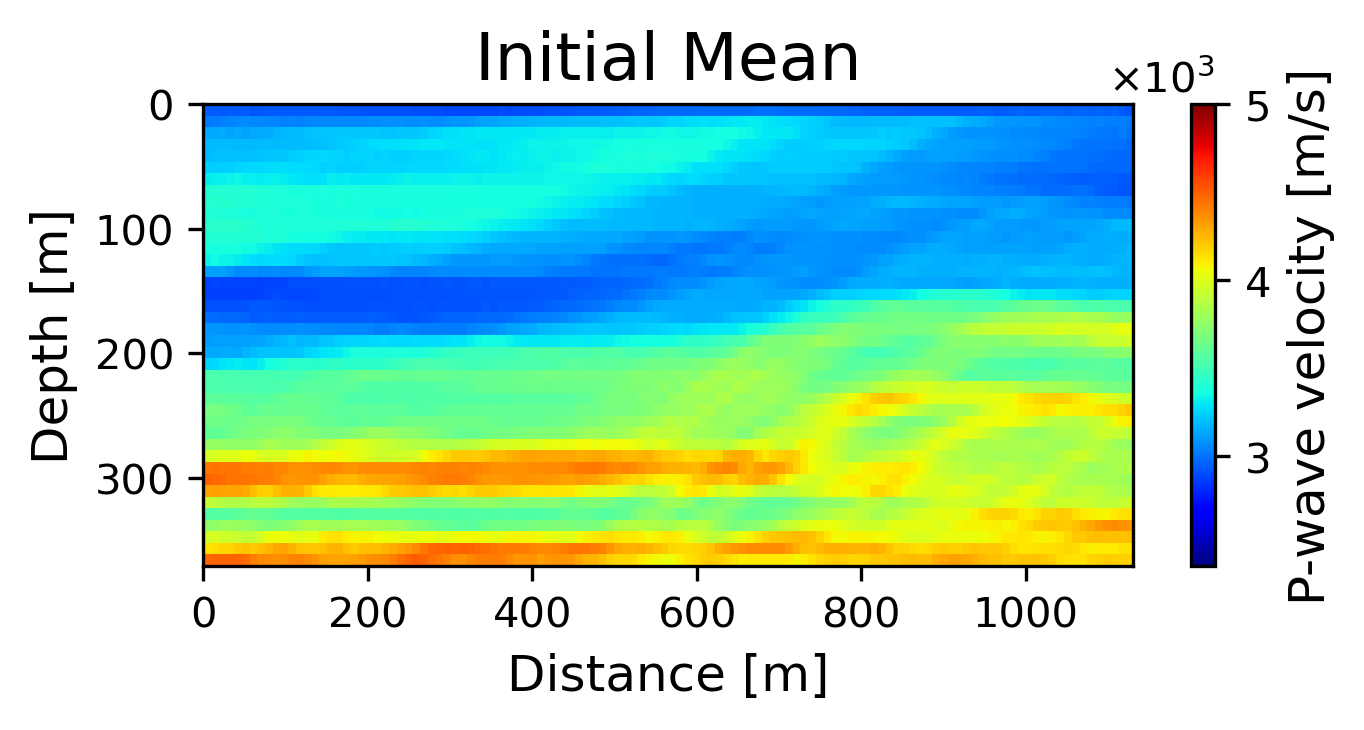

In [9]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions
tfb = tfp.bijectors

# Clone pre-trained generator
cond_generator = tf.keras.models.clone_model(generator)  # Clone generator
cond_generator.set_weights(generator.get_weights()) # Clone weights


@tf.custom_gradient
def dJ_dm(vel):
  loss_J = prop.misfit(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
  loss_J = tf.cast(loss_J, tf.float32)

  def grad_fn(upstream):
    grad = prop.adjoint_gradient(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    return upstream * tf.cast(grad, tf.float32)
  return loss_J, grad_fn

#########################################################
k = 10
ndim = 100
components = []

def normalize(var):
  # tfp.util.TransformedVariable(q_scale_init, tfp.bijectors.Exp(), trainable=True)
  scale = tf.reduce_sum(tf.nn.softplus(var))
  return tf.nn.softplus(var)/scale

for _ in range(k):
  mu_i = tf.random.normal(shape=[ndim])
  tril_i = tfp.util.TransformedVariable(
          tf.linalg.diag(tf.random.uniform([ndim], minval=0.2, maxval=0.5)), 
          tfp.bijectors.Exp(), 
          dtype=tf.float32,
          trainable=True,
          name='Tril')
  # tril_i = tf.Variable(tf.linalg.diag(tf.random.uniform([ndim], minval=0.2, maxval=0.5)),dtype=tf.float32)
  comp_i = tfd.MultivariateNormalTriL(loc=tf.Variable(mu_i,dtype=tf.float32, name='mu'), 
                            scale_tril=tril_i)
  components.append(comp_i)

gm = tfd.Mixture(
    cat=tfd.Categorical(probs=normalize(tf.random.normal([k],dtype=tf.float32))),
    components=components)
#########################################################

BATCH_SIZE = 25
loss_tracker = []
sigma2 = 1e-1  # Noise level
gm_optimizer = tf.keras.optimizers.Adam(1e-1)
epoch_vels = []
residuals_tracker = []
std_tracker = []

noise_z = gm.sample(BATCH_SIZE)
# Generate image from I(w)
Gz = cond_generator(noise_z, training=False)
Gz = inverse_norm(Gz[:,:,:,0],vmin,vmax)
v_init = tf.reshape(tf.reduce_mean(Gz,axis=0), -1)

plt.figure(figsize=(5,2),dpi=300)
plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.title("Initial Mean",fontsize=labelsize)

## Apply gradient to gaussian mixture parameters

Iteration 152


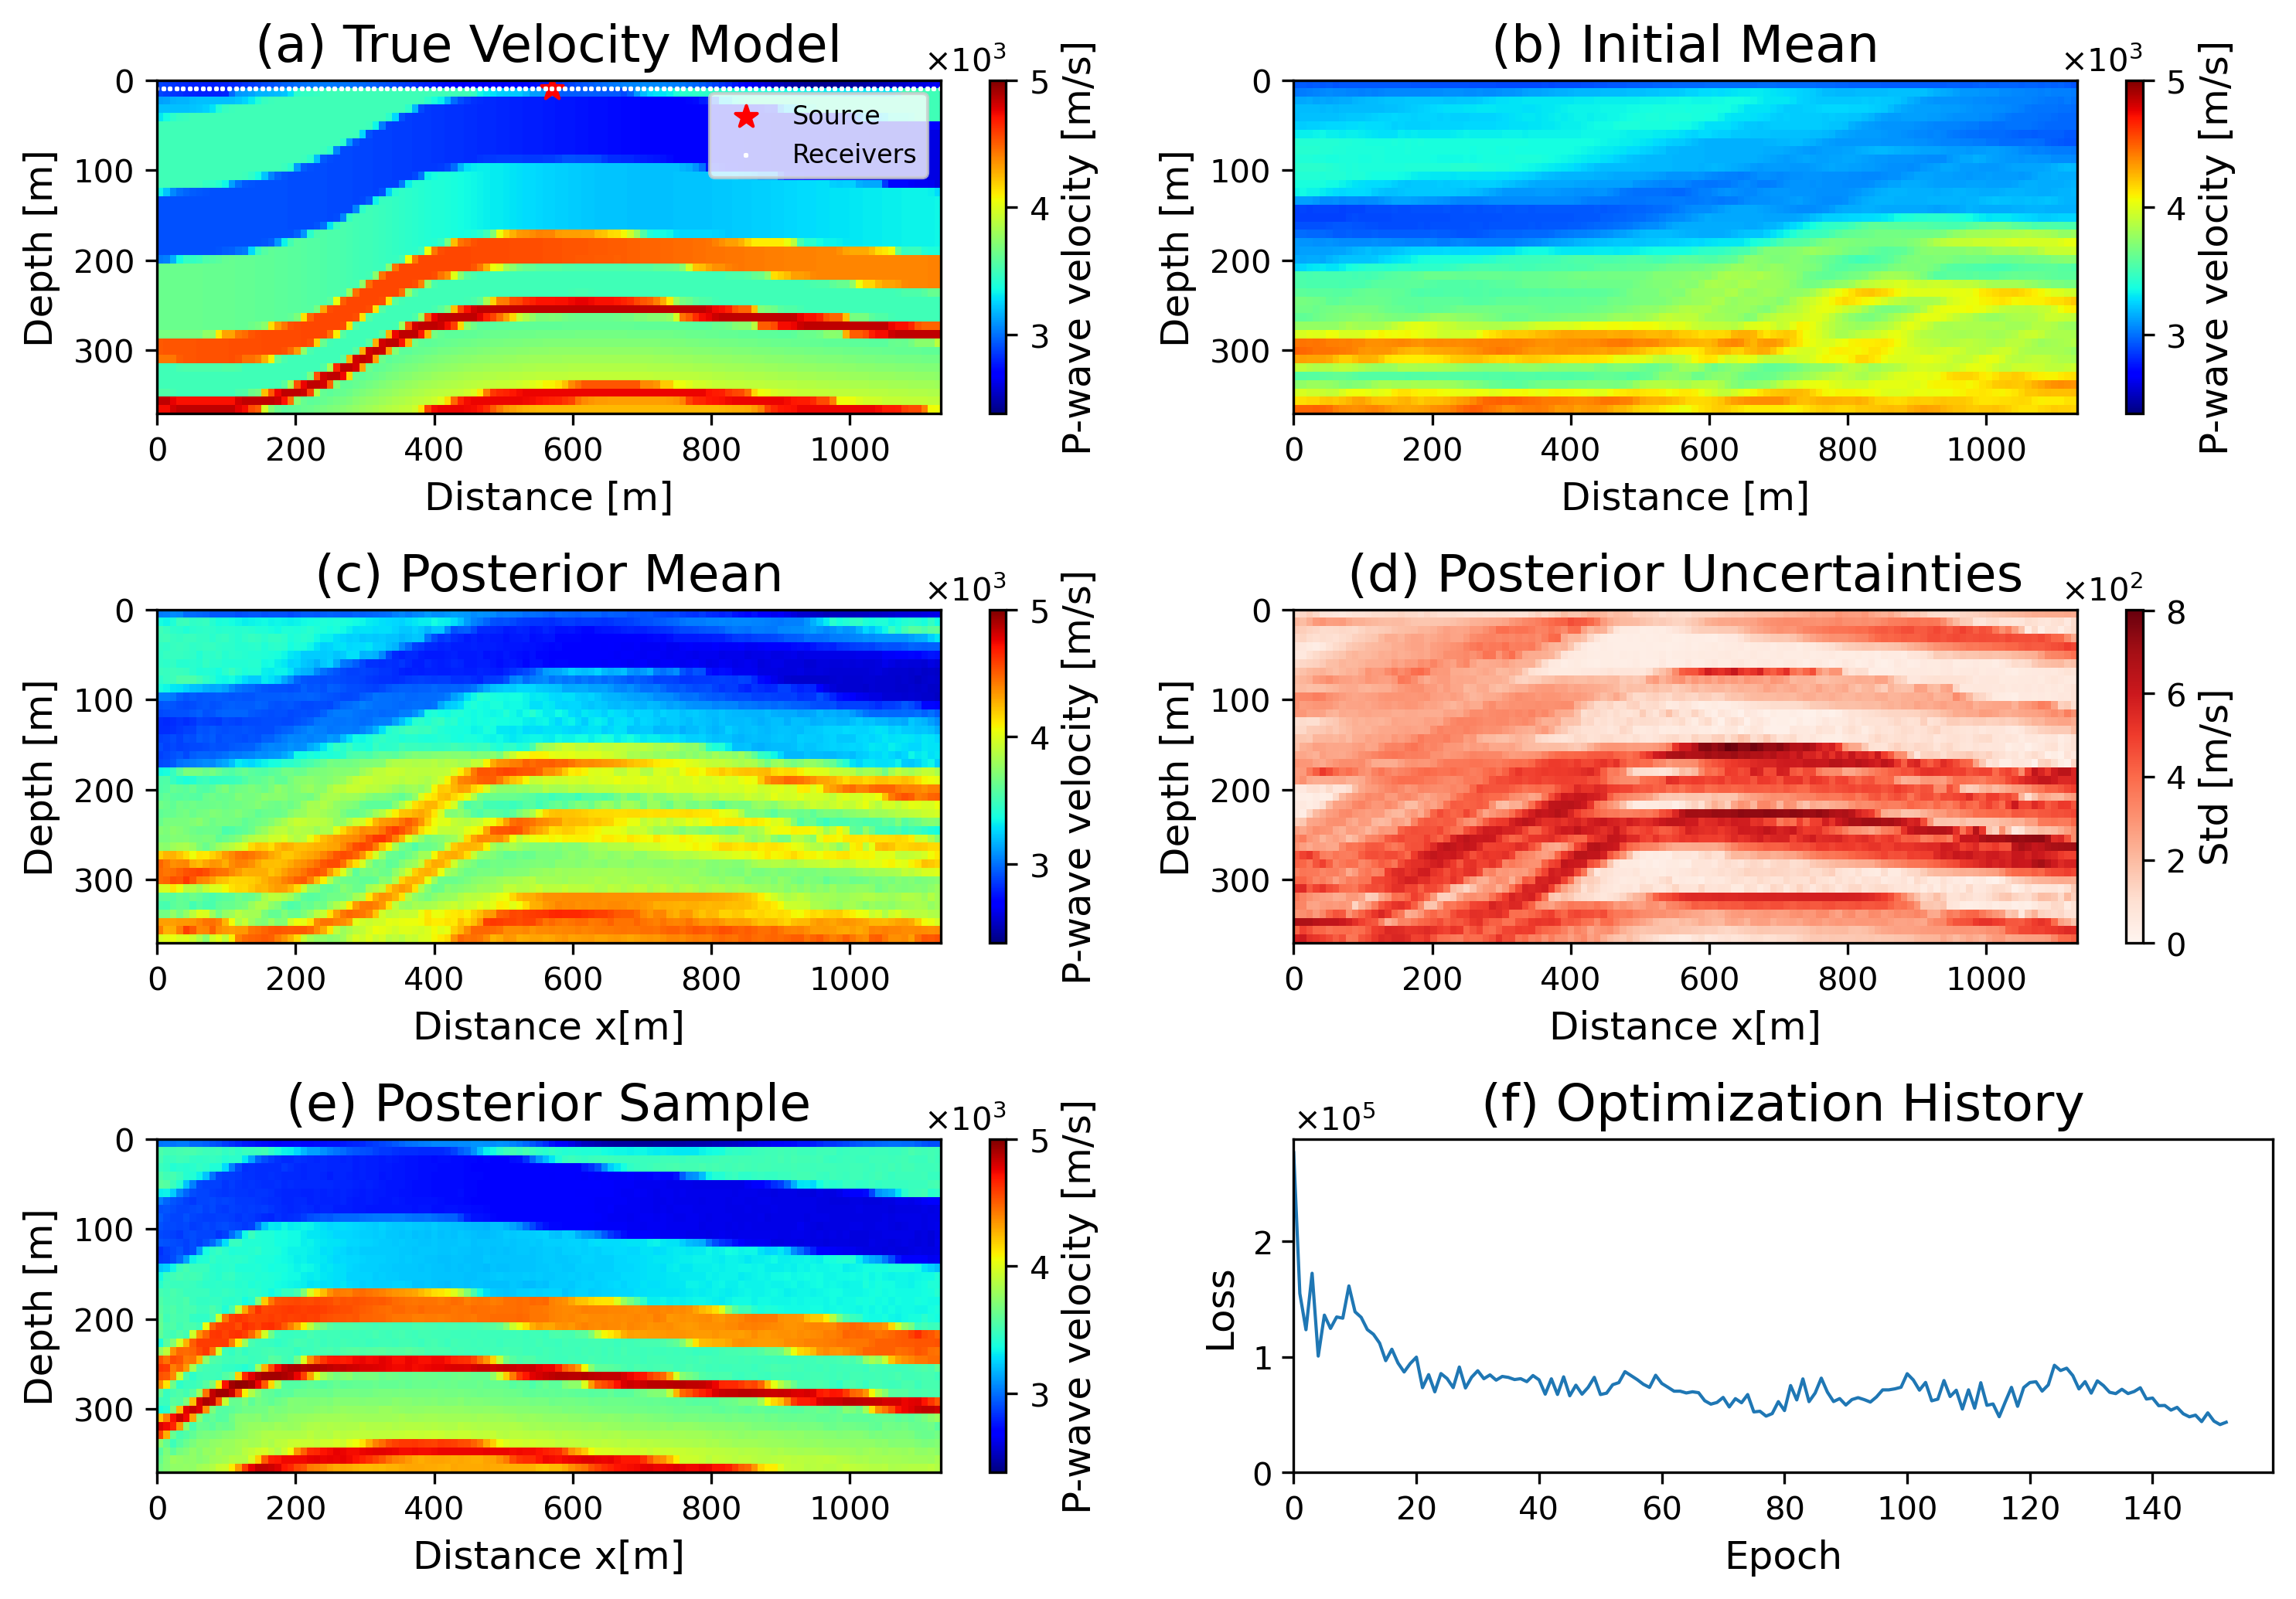

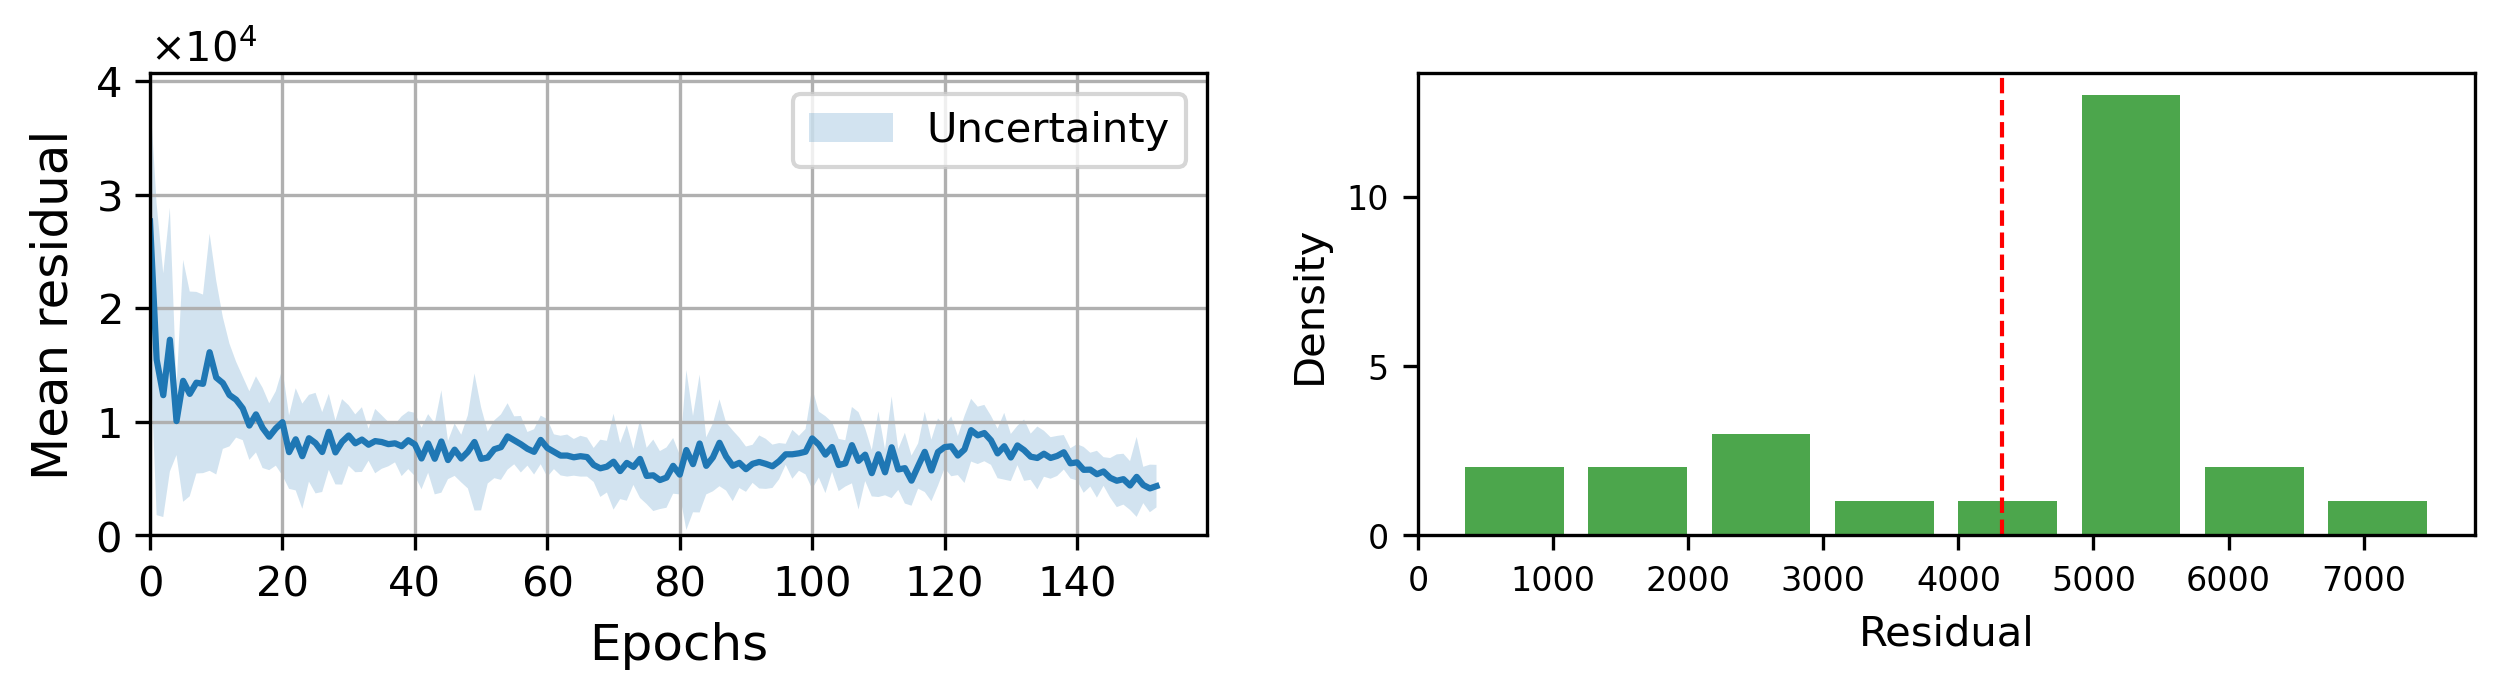

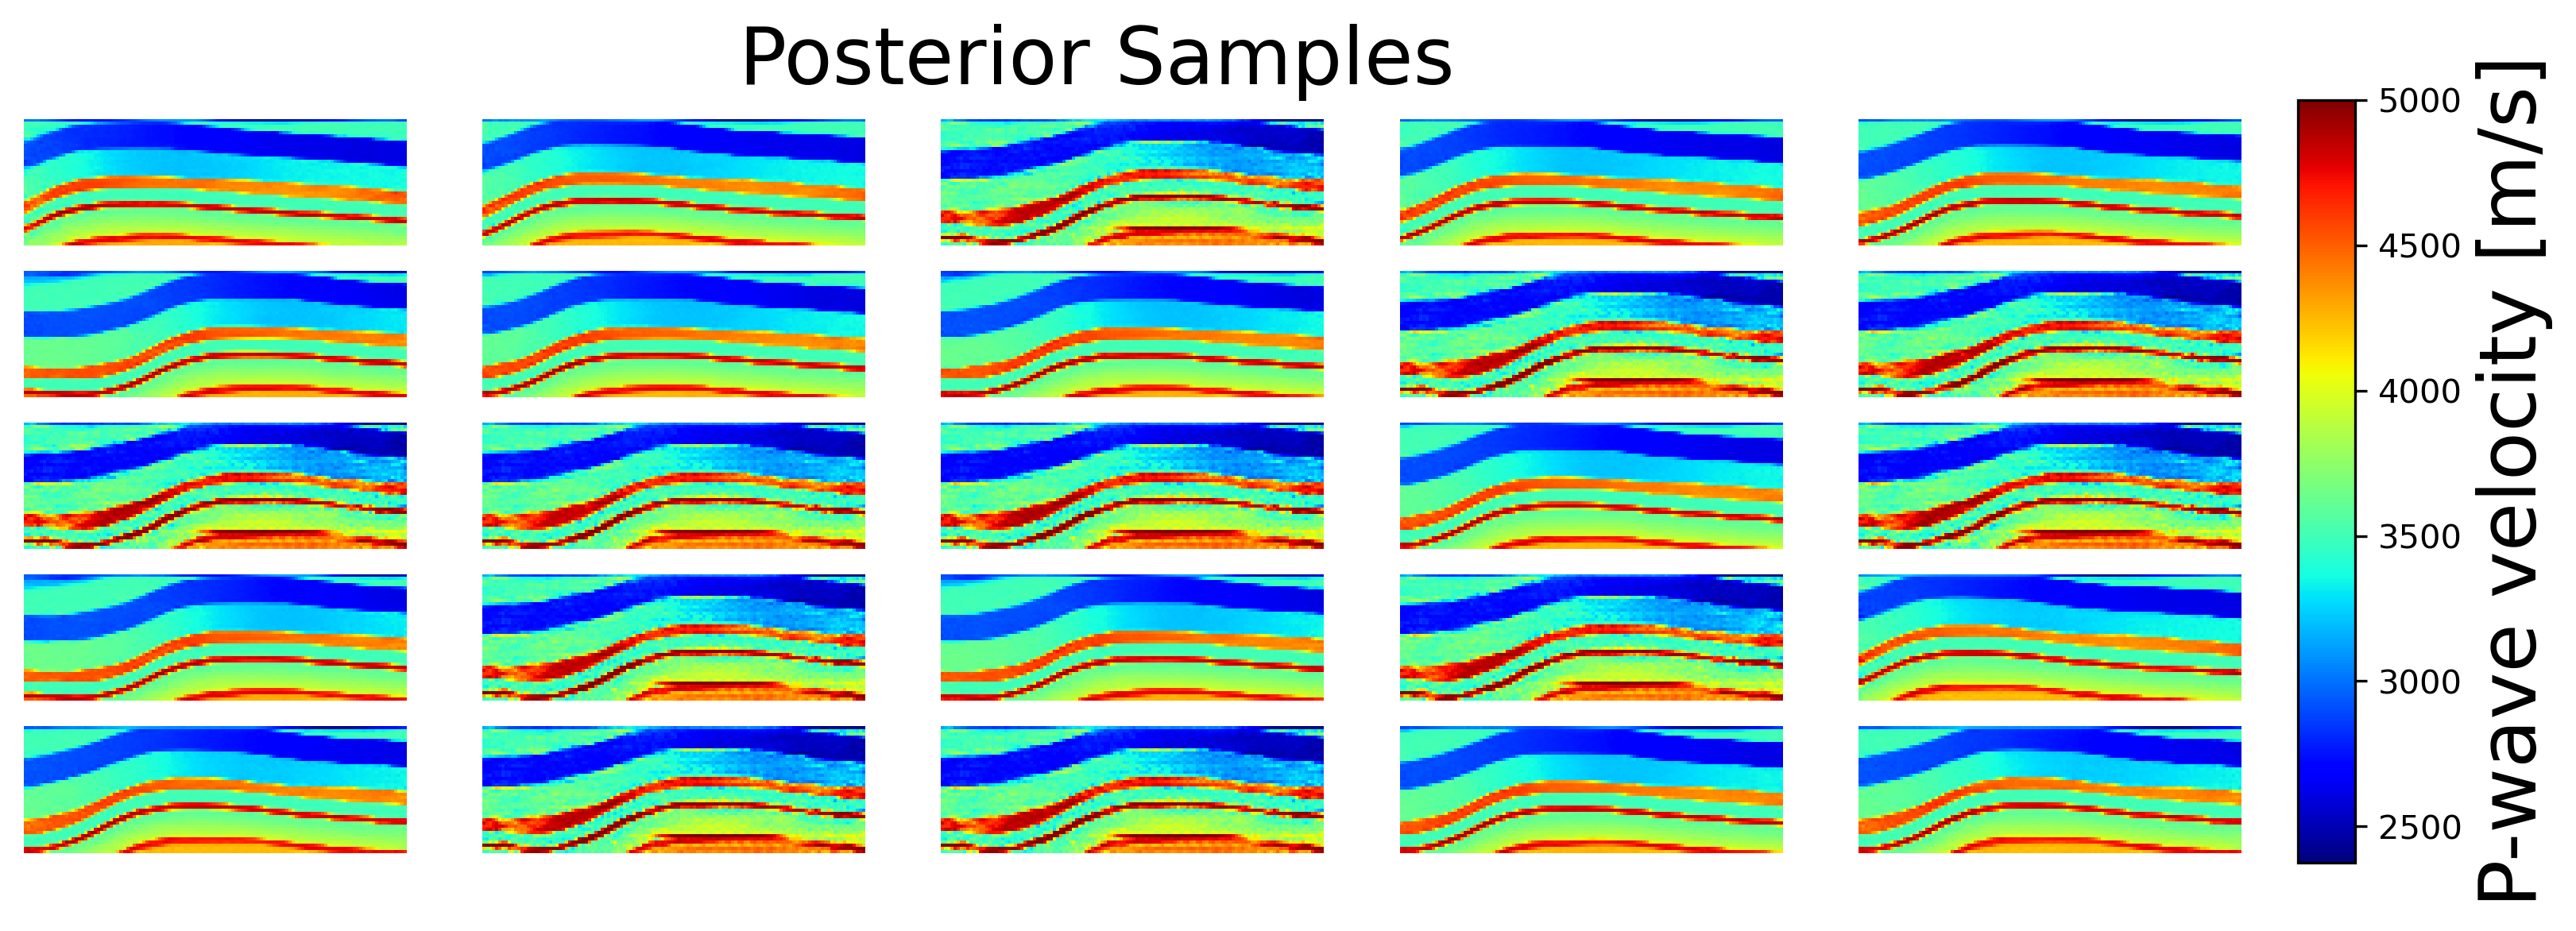

tf.Tensor(43359.08, shape=(), dtype=float32) tf.Tensor(30.275965, shape=(), dtype=float32)


KeyboardInterrupt: 

In [10]:
def plot_loss(epoch_vels, loss_list):
  # Display current velocity field
  clear_output(wait=True)
  print('Iteration', int(i))

  plt.figure(figsize=(10,7), dpi=300)
  # Plot the true velocity
  plt.subplot(321)
  plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=50,alpha=1,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.1,alpha=1,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(a) True Velocity Model",fontsize=labelsize)

  # Plot the initial velocity
  plt.subplot(322)
  plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(b) Initial Mean",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(323)
  plt.imshow(post_mean.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(c) Posterior Mean",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(324)
  plt.imshow(post_std.numpy().reshape((nz,nx)),vmin=0,cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("Std [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(d) Posterior Uncertainties",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(325)
  plt.imshow(epoch_vels[0].numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(e) Posterior Sample",fontsize=labelsize)

  # Display loss track
  plt.subplot(326)
  plt.plot(loss_list,lw=1)
  # Set the x-axis tick formatter to scientific notation
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
  plt.gca().yaxis.set_major_formatter(formatter)
  # plt.legend(['Data misfit'])
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlabel('Epoch', fontsize=labelsize-4)
  plt.ylabel('Loss', fontsize=labelsize-4)
  plt.title("(f) Optimization History",fontsize=labelsize)

  plt.tight_layout()
  plt.show()

  # Plot residuals
  plt.figure(figsize=(10,2), dpi=300)
  plt.subplot(121)
  plt.plot(residuals_tracker)
  plt.fill_between(np.arange(len(residuals_tracker)),np.array(residuals_tracker)-np.array(std_tracker), 
                    np.array(residuals_tracker)+np.array(std_tracker), alpha=0.2, label='Uncertainty')
  # Add labels, title, legend, etc.
  # Set the x-axis tick formatter to scientific notation
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
  plt.gca().yaxis.set_major_formatter(formatter)

  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlabel('Epochs', fontsize=labelsize-4)
  plt.ylabel('Mean residual', fontsize=labelsize-4)
  plt.legend()
  plt.grid(True)

  plt.subplot(122)
  plt.hist(residuals, bins=BATCH_SIZE//3, color ='green', alpha = 0.7, rwidth=0.8)
  plt.axvline(np.mean(residuals),color='red', linestyle='dashed', linewidth=1)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xticks(fontsize=labelsize-8)
  plt.yticks(fontsize=labelsize-8)
  plt.xlabel('Residual', fontsize=labelsize-6)
  plt.ylabel('Density', fontsize=labelsize-6)
  plt.show()

  # Plot realizations
  plt.figure(figsize=(12, 4),dpi=300)
  plt.suptitle("Posterior Samples", fontsize=24)
  for k in range(25):
    plt.subplot(5, 5, k+1)
    plt.imshow(epoch_vels[k].numpy().reshape((nz,nx)),cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
    plt.axis('off')
  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cb = plt.colorbar(cax=cax)
  cb.set_label("P-wave velocity [m/s]", fontsize=24)
  plt.show()

for i in range(500):
  # grad = tape.gradient(J, v_gan)
  with tf.GradientTape(persistent=True) as tape:
    noise_z = gm.sample(BATCH_SIZE)
    # Gz = cond_generator(noise_z, training=False)
    # Gz = inverse_norm(Gz[:,:,:,0],vmin,vmax)
    epoch_losses = []
    epoch_vels = []
    residuals = []
    for j in range(BATCH_SIZE):
      print('.',end='')
      noise_z_i = noise_z[j:j+1,:]
      # Generate image from I(w)
      Gz = cond_generator(noise_z_i, training=False)
      Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
      m = tf.reshape(Gz, -1)
      # Forward propagation & Adjoint back propagation
      J = dJ_dm(m)
      neg_log_post = J/(1e-6+sigma2) + tf.reduce_sum(noise_z[j,:]**2)
      # Save generated velocity fields and loss
      residuals.append(J)
      epoch_vels.append(m)
      epoch_losses.append(neg_log_post)
    
    # Compute Posterior Mean velocity
    post_mean = tf.reduce_mean(epoch_vels,axis=0)
    post_std = tf.math.reduce_std(epoch_vels,axis=0)

    # Negative Entropy loss
    log_prob = tf.reduce_mean(gm.log_prob(noise_z))
    # Compute averate loss of this epoch's batch
    # print(tf.reduce_mean(epoch_losses),log_prob)
    epoch_loss = tf.reduce_mean(epoch_losses) + log_prob

  # Save loss
  loss_tracker.append(epoch_loss)
  residuals_tracker.append(np.mean(residuals))
  std_tracker.append(np.std(residuals))
  plot_loss(epoch_vels, loss_tracker)
  print(tf.reduce_mean(epoch_losses),log_prob)

  # Compute gradient of loss w.r.t.
  grad = tape.gradient(epoch_loss, gm.trainable_variables)
  # print('Sum of dJ|dw',sum([tf.reduce_sum(tf.abs(g)) for g in grad]).numpy())
  gm_optimizer.apply_gradients(zip(grad, gm.trainable_variables))

In [62]:
w = tf.random.normal([1,dim_w])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(w)
  noise_z = flow(w)
jac = tape.jacobian(noise_z, w)
jac = tf.reshape(jac,[100,100])
print(jac)
# det = tf.linalg.det(jac)
# jac = tf.reshape(jac,[100,100])

z = tf.random.normal([dim_w])
def gaussian_pdf(x):
  coefficient = 1.0 / tf.sqrt(2.0 * tf.constant(3.141592653589793))
  exponent = -tf.square(x) / 2.0
  return coefficient * tf.exp(exponent)

gaussian_pdf(z)

tf.Tensor(
[[ 6.59714162e-01 -2.44450779e-03 -7.68502057e-03 ... -6.59552366e-02
   5.84532693e-03 -2.42306851e-04]
 [-1.92952994e-02  6.38514221e-01  1.58399635e-03 ... -3.87348495e-02
  -5.06443940e-02  5.68672866e-02]
 [ 5.32548968e-03 -3.80146038e-03  5.23862243e-01 ...  4.46422771e-03
  -3.63209546e-02 -8.27435106e-02]
 ...
 [-1.03183486e-01  3.46566886e-02 -1.92951001e-02 ...  1.84919024e+00
  -4.40685749e-02  6.23241812e-02]
 [ 2.00809240e-02  3.88595201e-02 -8.10708664e-03 ... -2.38964446e-02
   1.07081866e+00  3.34380707e-03]
 [-1.77821107e-02 -2.39983313e-02 -1.25355963e-02 ...  2.18178667e-02
   2.99949711e-03  1.00751150e+00]], shape=(100, 100), dtype=float32)


## Posterior Samples

In [ ]:
fig = plt.figure(figsize=(12, 6),dpi=300)
plt.suptitle("Posterior Samples", fontsize=24)
for k in range(12):
  plt.subplot(4, 3, k+1)
  plt.imshow(epoch_vels[k].numpy().reshape((nz,nx)),cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=24)
plt.show()